# 2-Stage In-Plane Rigid Registration: CT ↔ Ultrasound (CFRP)

## Overview

This notebook implements a **production-ready, 2-stage rigid registration pipeline** for aligning **CT (X-ray Computed Tomography)** volumes to **Ultrasound (US)** volumes of CFRP (Carbon Fiber Reinforced Polymer) parts. The registration is **constrained to in-plane motion only**:

- **Translations**: X (tx), Y (ty) — **free**
- **Rotation**: Z-axis (rz) — **optional** (configurable)
- **Locked DOF**: Z translation (tz) and X/Y rotations (rx, ry) are **fixed at zero**

### Key Assumptions
- **Z-axis alignment is already correct** (e.g., from a separate coarse alignment step)
- Both volumes image the **same CFRP part** with sufficient overlap
- Physical spacings (voxel sizes in mm) are known or can be estimated
- CT has high SNR with visible porosity; US has speckle and anisotropic resolution

### Workflow Summary

1. **Environment Check**: Validate dependencies (SimpleITK, NumPy, etc.)
2. **Configuration**: Single `CONFIG` dict with all paths, spacings, and hyperparameters
3. **Stage 1 (Coarse)**: 
   - Resample both volumes to **isotropic** spacing (~0.8 mm)
   - Robust global alignment using Mattes Mutual Information (MI)
   - Constrained rigid registration with in-plane DOF only
4. **Stage 2 (Fine)**:
   - CT resampled to finer isotropic spacing (~0.5 mm)
   - US kept at **native** (anisotropic) resolution
   - Refine alignment initialized from Stage 1
   - Use overlap mask from pre-warped Stage 1 result
5. **Quality Control**:
   - Visual overlays (fixed + moving superimposed)
   - Quantitative validation (Dice coefficient in both spaces)
   - Transform parameter inspection
6. **Exports**:
   - Transforms saved as `.tfm` or `.h5` files
   - CT resampled into US space (normalized + raw intensities)
   - Comprehensive logs and QC images

### Coordinate Convention
- **Volume shape**: `(Z, Y, X)` where Z is the depth/scan axis
- **Spacing**: `(dz, dy, dx)` in mm
- **Transform direction**: `registration.Execute(fixed=US, moving=CT)` produces **CT→US** transform
  - To get US→CT (for QC in CT space), use the **inverse** transform

### Usage
1. Edit **Cell 2 (`CONFIG`)** with your file paths and spacings
2. Run **Cell 12** to execute the full pipeline
3. Review QC cells (13-17) to validate alignment
4. Inspect transform parameters (Cell 17) to verify constraints

---

**Author**: Medical Imaging Registration Pipeline  
**Date**: 2025-10  
**License**: Open for research use


In [ ]:
# Cell 1: Environment Check & Dependency Validation
# =====================================================

import sys
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("=" * 70)
print("ENVIRONMENT CHECK")
print("=" * 70)

# Check Python version
print(f"\nPython version: {sys.version}")
py_ver = sys.version_info
if py_ver.major < 3 or (py_ver.major == 3 and py_ver.minor < 10):
    print("⚠️  WARNING: Python 3.10+ recommended. You have {}.{}.{}".format(
        py_ver.major, py_ver.minor, py_ver.micro))
else:
    print(f"✓ Python {py_ver.major}.{py_ver.minor}.{py_ver.micro} (OK)")

print("\n" + "-" * 70)
print("DEPENDENCY VERSIONS")
print("-" * 70)

# Core dependencies
try:
    import numpy as np
    print(f"✓ NumPy: {np.__version__}")
except ImportError:
    print("✗ NumPy: NOT FOUND")
    sys.exit(1)

try:
    import scipy
    print(f"✓ SciPy: {scipy.__version__}")
except ImportError:
    print("✗ SciPy: NOT FOUND")
    sys.exit(1)

try:
    import matplotlib
    print(f"✓ Matplotlib: {matplotlib.__version__}")
except ImportError:
    print("✗ Matplotlib: NOT FOUND")
    sys.exit(1)

try:
    import tifffile
    print(f"✓ tifffile: {tifffile.__version__}")
except ImportError:
    print("✗ tifffile: NOT FOUND (install with: pip install tifffile)")
    sys.exit(1)

# Critical: SimpleITK
try:
    import SimpleITK as sitk
    print(f"✓ SimpleITK: {sitk.Version.VersionString()}")
    print(f"  Build: {sitk.Version.BuildDate()}")
except ImportError:
    print("\n" + "!" * 70)
    print("✗ SimpleITK: NOT FOUND")
    print("!" * 70)
    print("\nSimpleITK is REQUIRED for this notebook.")
    print("\nInstallation instructions:")
    print("  conda install -c simpleitk simpleitk")
    print("  OR")
    print("  pip install SimpleITK")
    print("\nAfter installation, restart the kernel and re-run this cell.")
    print("!" * 70)
    sys.exit(1)

print("\n" + "=" * 70)
print("✓ ALL DEPENDENCIES AVAILABLE")
print("=" * 70)
print("\nYou can now proceed to configure and run the registration pipeline.\n")


ENVIRONMENT CHECK

Python version: 3.13.2 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:56:02) [GCC 11.2.0]
✓ Python 3.13.2 (OK)

----------------------------------------------------------------------
DEPENDENCY VERSIONS
----------------------------------------------------------------------
✓ NumPy: 2.2.5
✓ SciPy: 1.15.3
✓ Matplotlib: 3.10.0
✓ tifffile: 2025.2.18
✓ SimpleITK: 2.5.2
  Build: Jun 13 2025 19:16:44

✓ ALL DEPENDENCIES AVAILABLE

You can now proceed to configure and run the registration pipeline.



In [ ]:
# Cell 2: CONFIGURATION — Edit this cell only!
# ==============================================
# This is the ONLY cell you need to modify to run the pipeline.
# All paths, spacings, and hyperparameters are defined here.

CONFIG = {
    # ======================================================================
    # PATHS (Edit these to point to your data)
    # ======================================================================
    'CT_PATH': '/home/apollo/Dev/Data/JI_7_aligned_90rotright_reslicetop.tif',
    'US_PATH': '/home/apollo/Dev/Data/JI_7_env.tif',
    'OUTPUT_DIR': './outputs/registration_inplane_test',
    
    # ======================================================================
    # PHYSICAL SPACINGS (mm) — CRITICAL FOR CORRECT REGISTRATION
    # ======================================================================
    # Format: (dz, dy, dx) where Z is depth/scan axis
    'CT_SPACING_MM': (0.025, 0.025, 0.025),  # Isotropic CT
    'US_SPACING_MM': (0.016, 1.0, 1.0),      # Anisotropic US (typical for PAUT)
    
    # ======================================================================
    # STAGE 1: COARSE ALIGNMENT (isotropic resampling for both)
    # ======================================================================
    'STAGE1_SPACING_MM': 0.8,  # Coarse isotropic spacing (mm)
    
    # ======================================================================
    # STAGE 2: FINE ALIGNMENT
    # ======================================================================
    'STAGE2_CT_SPACING_MM': 0.5,       # Fine isotropic spacing for CT (mm)
    'STAGE2_US_KEEP_NATIVE': True,     # Keep US at native (anisotropic) resolution
    
    # ======================================================================
    # DEGREES OF FREEDOM (DOF) CONSTRAINTS
    # ======================================================================
    # Set ALLOW_RZ=True to allow rotation around Z-axis (in-plane rotation)
    # Set ALLOW_RZ=False for pure translation (tx, ty only)
    'ALLOW_RZ': True,
    
    # ======================================================================
    # PREPROCESSING
    # ======================================================================
    'CT_CLIP_PERCENTILES': (2, 98),          # Clip CT intensities (p_low, p_high)
    'US_GAUSSIAN_SIGMA_VOXELS': 0.5,         # Gaussian smoothing for US (voxels)
    'US_CLIP_PERCENTILES': (0, 100),          # Clip US intensities
    'US_LOG_COMPRESSION': False,              # Apply log compression to US
    
    # ======================================================================
    # REGISTRATION HYPERPARAMETERS
    # ======================================================================
    'MI_BINS': 1024,                           # Mattes MI histogram bins
    'SAMPLING_PERCENT': 0.05,                # Random voxel sampling (5%)
    'SHRINK_FACTORS': [4, 2, 1],          # Multi-resolution pyramid
    'SMOOTHING_SIGMAS_MM': [2.5, 1.5, 0.0],  # Smoothing per level (mm)
    'MAX_ITERS_PER_LEVEL': 1000000,              # Max iterations per pyramid level
    'LEARNING_RATE': 1.0,                    # Initial optimizer learning rate
    'MIN_STEP_LENGTH': 1e-12,                 # Minimum step size (convergence)
    'RELAXATION_FACTOR': 0.5,                # Optimizer relaxation
    
    # ======================================================================
    # REPRODUCIBILITY
    # ======================================================================
    'RANDOM_SEED': 111,                       # Fixed seed for sampling
    
    # ======================================================================
    # QC / VISUALIZATION
    # ======================================================================
    'QC_NUM_SLICES': 7,                      # Number of slices to show in overlays
}

print("✓ Configuration loaded successfully.")
print(f"  CT: {CONFIG['CT_PATH']}")
print(f"  US: {CONFIG['US_PATH']}")
print(f"  Output: {CONFIG['OUTPUT_DIR']}")
print(f"  In-plane rotation (Rz): {'ALLOWED' if CONFIG['ALLOW_RZ'] else 'LOCKED'}")


✓ Configuration loaded successfully.
  CT: /home/apollo/Dev/Data/JI_7_aligned_90rotright_reslicetop.tif
  US: /home/apollo/Dev/Data/JI_7_env.tif
  Output: ./outputs/registration_inplane_test
  In-plane rotation (Rz): ALLOWED


In [ ]:
# Cell 3: I/O Utilities
# =======================
# Functions for reading/writing volumes and transforms

import os
import SimpleITK as sitk
import numpy as np
import tifffile
from pathlib import Path

def read_volume(path, spacing_mm=None, origin=None, direction=None):
    """
    Read a 3D volume from disk and convert to SimpleITK Image with proper metadata.
    
    Supports TIFF (via tifffile) and other formats (via SimpleITK).
    
    Parameters
    ----------
    path : str
        Path to volume file (.tif, .tiff, .nii, .nii.gz, .mha, etc.)
    spacing_mm : tuple of float, optional
        Physical spacing (dz, dy, dx) in mm. If None, uses file metadata or (1,1,1).
    origin : tuple of float, optional
        Physical origin. If None, uses (0,0,0).
    direction : tuple of float, optional
        Direction cosine matrix (9 elements, row-major). If None, uses identity.
    
    Returns
    -------
    sitk.Image
        Volume with proper spacing, origin, and direction set.
    """
    path = str(path)
    
    if not os.path.exists(path):
        raise FileNotFoundError(f"Volume not found: {path}")
    
    # Try TIFF first (common for microscopy/CT)
    if path.lower().endswith(('.tif', '.tiff')):
        arr = tifffile.imread(path)
        # Convert to float32 for processing
        arr = arr.astype(np.float32)
        img = sitk.GetImageFromArray(arr)
    else:
        # Use SimpleITK for other formats
        img = sitk.ReadImage(path)
        img = sitk.Cast(img, sitk.sitkFloat32)
    
    # Set or override spacing
    if spacing_mm is not None:
        img.SetSpacing(spacing_mm[::-1])  # SimpleITK uses (x, y, z)
    elif img.GetSpacing() == (1.0, 1.0, 1.0):
        print(f"  ⚠️  WARNING: No spacing in file metadata for {Path(path).name}")
        print(f"     Using default (1, 1, 1) mm. Consider setting spacing_mm explicitly.")
    
    # Set origin if provided
    if origin is not None:
        img.SetOrigin(origin[::-1])
    
    # Set direction if provided
    if direction is not None:
        img.SetDirection(direction)
    
    return img


def write_volume(img, path, compress=True):
    """
    Write a SimpleITK Image to disk.
    
    Parameters
    ----------
    img : sitk.Image
        Image to save.
    path : str
        Output path (.tif, .nii.gz, .mha, etc.)
    compress : bool
        Enable compression (for TIFF, uses LZW; for NIfTI, gzip).
    """
    path = str(path)
    os.makedirs(os.path.dirname(path) or '.', exist_ok=True)
    
    if path.lower().endswith(('.tif', '.tiff')):
        # Save as TIFF via tifffile for better control
        arr = sitk.GetArrayFromImage(img)
        tifffile.imwrite(path, arr, compression='zlib' if compress else None)
    else:
        sitk.WriteImage(img, path, compress)
    
    print(f"  ✓ Saved: {path}")


def write_transform(transform, path):
    """
    Write a SimpleITK Transform to disk.
    
    Saves as .tfm (preferred) or .h5 (for composite transforms).
    
    Parameters
    ----------
    transform : sitk.Transform
        Transform to save.
    path : str
        Output path (will use .tfm or .h5 extension).
    """
    path = str(path)
    os.makedirs(os.path.dirname(path) or '.', exist_ok=True)
    
    # For composite transforms, must use HDF5
    if isinstance(transform, sitk.CompositeTransform) or not hasattr(transform, 'WriteTransform'):
        path_h5 = path.replace('.tfm', '.h5')
        sitk.WriteTransform(transform, path_h5)
        print(f"  ✓ Saved transform: {path_h5}")
    else:
        try:
            sitk.WriteTransform(transform, path)
            print(f"  ✓ Saved transform: {path}")
        except Exception as e:
            # Fallback to HDF5
            path_h5 = path.replace('.tfm', '.h5')
            sitk.WriteTransform(transform, path_h5)
            print(f"  ✓ Saved transform (HDF5): {path_h5}")


def numpy_to_sitk(arr, spacing=(1.0, 1.0, 1.0), origin=(0.0, 0.0, 0.0), direction=None):
    """
    Convert NumPy array to SimpleITK Image with metadata.
    
    Parameters
    ----------
    arr : np.ndarray
        3D array with shape (Z, Y, X).
    spacing : tuple of float
        Physical spacing (dz, dy, dx) in mm.
    origin : tuple of float
        Physical origin (oz, oy, ox) in mm.
    direction : tuple of float, optional
        9-element direction cosine matrix. If None, uses identity.
    
    Returns
    -------
    sitk.Image
    """
    img = sitk.GetImageFromArray(arr.astype(np.float32))
    img.SetSpacing(spacing[::-1])  # SimpleITK: (x, y, z)
    img.SetOrigin(origin[::-1])
    if direction is not None:
        img.SetDirection(direction)
    return img


def sitk_to_numpy(img):
    """
    Convert SimpleITK Image to NumPy array and extract metadata.
    
    Parameters
    ----------
    img : sitk.Image
    
    Returns
    -------
    arr : np.ndarray
        Array with shape (Z, Y, X).
    metadata : dict
        Dictionary with 'spacing', 'origin', 'direction' in (Z, Y, X) order.
    """
    arr = sitk.GetArrayFromImage(img)
    spacing_xyz = img.GetSpacing()
    origin_xyz = img.GetOrigin()
    direction = img.GetDirection()
    
    metadata = {
        'spacing': spacing_xyz[::-1],    # Convert to (z, y, x)
        'origin': origin_xyz[::-1],
        'direction': direction,
        'size': img.GetSize()[::-1]
    }
    return arr, metadata


print("✓ I/O utilities loaded.")


✓ I/O utilities loaded.


In [ ]:
# Cell 4: Preprocessing Functions
# ==================================
# Intensity normalization for CT and US

import SimpleITK as sitk
import numpy as np

def compute_percentiles(img_sitk, p_low, p_high):
    """
    Compute percentile values from a SimpleITK Image.
    
    Parameters
    ----------
    img_sitk : sitk.Image
    p_low, p_high : float
        Percentile values (0-100).
    
    Returns
    -------
    val_low, val_high : float
    """
    arr = sitk.GetArrayFromImage(img_sitk)
    val_low = np.percentile(arr, p_low)
    val_high = np.percentile(arr, p_high)
    return val_low, val_high


def normalize_ct(img_sitk, percentiles=(2, 98)):
    """
    Normalize CT volume: percentile clipping → rescale to [0, 1].
    
    Parameters
    ----------
    img_sitk : sitk.Image
        Input CT volume (float32).
    percentiles : tuple of float
        (p_low, p_high) for clipping.
    
    Returns
    -------
    sitk.Image
        Normalized volume with intensities in [0, 1].
    """
    p_low, p_high = percentiles
    val_low, val_high = compute_percentiles(img_sitk, p_low, p_high)
    
    # Convert to Python floats (SimpleITK doesn't accept NumPy scalars)
    val_low = float(val_low)
    val_high = float(val_high)
    
    # Clamp intensities
    img_clipped = sitk.Clamp(img_sitk, sitk.sitkFloat32, val_low, val_high)
    
    # Rescale to [0, 1]
    if val_high > val_low:
        img_norm = (img_clipped - val_low) / (val_high - val_low)
    else:
        img_norm = img_clipped * 0.0  # All same value → zero
    
    return img_norm


def normalize_us(img_sitk, sigma_voxels=1.0, percentiles=(1, 99), log_compress=True):
    """
    Normalize US volume: Gaussian smoothing → percentile clip → log compression → [0,1].
    
    Parameters
    ----------
    img_sitk : sitk.Image
        Input US volume (float32).
    sigma_voxels : float
        Gaussian smoothing sigma in voxels (speckle reduction).
    percentiles : tuple of float
        (p_low, p_high) for clipping.
    log_compress : bool
        Apply log1p transformation to compress dynamic range.
    
    Returns
    -------
    sitk.Image
        Normalized US volume in [0, 1].
    """
    # Step 1: Gaussian smoothing (speckle reduction)
    if sigma_voxels > 0:
        img_smooth = sitk.SmoothingRecursiveGaussian(img_sitk, sigma_voxels)
    else:
        img_smooth = img_sitk
    
    # Step 2: Percentile clipping
    p_low, p_high = percentiles
    val_low, val_high = compute_percentiles(img_smooth, p_low, p_high)
    
    # Convert to Python floats (SimpleITK doesn't accept NumPy scalars)
    val_low = float(val_low)
    val_high = float(val_high)
    
    img_clipped = sitk.Clamp(img_smooth, sitk.sitkFloat32, val_low, val_high)
    
    # Step 3: Rescale to [0, 1]
    if val_high > val_low:
        img_scaled = (img_clipped - val_low) / (val_high - val_low)
    else:
        img_scaled = img_clipped * 0.0
    
    # Step 4: Optional log compression
    if log_compress:
        # log1p(2*x) to compress dynamic range
        arr = sitk.GetArrayFromImage(img_scaled)
        arr_log = np.log1p(2.0 * arr)
        # Renormalize to [0, 1]
        if arr_log.max() > 0:
            arr_log = arr_log / arr_log.max()
        img_log = sitk.GetImageFromArray(arr_log)
        img_log.CopyInformation(img_scaled)
        return img_log
    else:
        return img_scaled


print("✓ Preprocessing functions loaded.")


✓ Preprocessing functions loaded.


In [ ]:
# Cell 5: Mask Generation
# =========================
# Create binary masks for CT and US to guide registration

import SimpleITK as sitk
import numpy as np

def create_ct_mask(img_sitk_normalized):
    """
    Create CT mask: Otsu threshold → morphological closing → keep largest component.
    
    Parameters
    ----------
    img_sitk_normalized : sitk.Image
        Normalized CT volume ([0, 1] range).
    
    Returns
    -------
    sitk.Image
        Binary mask (UInt8: 0 or 1).
    """
    # Otsu thresholding
    # Note: For CT, material is typically brighter, but if inverted, swap inside/outside
    otsu_filter = sitk.OtsuThresholdImageFilter()
    otsu_filter.SetInsideValue(0)  # Swapped: below threshold = background
    otsu_filter.SetOutsideValue(1)  # Swapped: above threshold = foreground (material)
    mask = otsu_filter.Execute(img_sitk_normalized)
    
    # Morphological closing to fill small gaps (radius in mm)
    spacing = img_sitk_normalized.GetSpacing()
    radius_mm = 2.0  # 2 mm radius
    radius_voxels = [int(np.ceil(radius_mm / sp)) for sp in spacing]
    mask = sitk.BinaryMorphologicalClosing(mask, radius_voxels)
    
    # Keep only the largest connected component
    cc_filter = sitk.ConnectedComponentImageFilter()
    labeled = cc_filter.Execute(mask)
    
    # Compute size of each label
    stats_filter = sitk.LabelShapeStatisticsImageFilter()
    stats_filter.Execute(labeled)
    
    if stats_filter.GetNumberOfLabels() == 0:
        print("  ⚠️  WARNING: No foreground in CT mask after Otsu. Using full volume.")
        return sitk.Cast(mask, sitk.sitkUInt8)
    
    # Find largest label
    largest_label = max(stats_filter.GetLabels(), key=lambda l: stats_filter.GetNumberOfPixels(l))
    
    # Extract largest component
    mask_largest = sitk.BinaryThreshold(labeled, largest_label, largest_label, 1, 0)
    mask_largest = sitk.Cast(mask_largest, sitk.sitkUInt8)
    
    return mask_largest


def create_us_mask(img_sitk_normalized, threshold=0.05):
    """
    Create US mask: simple threshold to exclude low-intensity background/shadows.
    
    Parameters
    ----------
    img_sitk_normalized : sitk.Image
        Normalized US volume ([0, 1] range).
    threshold : float
        Intensity threshold (typically 0.05-0.1 for normalized US).
    
    Returns
    -------
    sitk.Image
        Binary mask (UInt8: 0 or 1).
    """
    mask = sitk.BinaryThreshold(img_sitk_normalized, threshold, 1.0, 1, 0)
    mask = sitk.Cast(mask, sitk.sitkUInt8)
    return mask


def intersect_masks(mask1, mask2):
    """
    Compute intersection (AND) of two binary masks.
    
    Parameters
    ----------
    mask1, mask2 : sitk.Image
        Binary masks (UInt8).
    
    Returns
    -------
    sitk.Image
        Binary mask (UInt8).
    """
    return sitk.And(mask1, mask2)


def dilate_mask(mask, radius_mm=2.0):
    """
    Dilate a binary mask by a given radius (in mm).
    
    Parameters
    ----------
    mask : sitk.Image
        Binary mask (UInt8).
    radius_mm : float
        Dilation radius in mm.
    
    Returns
    -------
    sitk.Image
        Dilated mask (UInt8).
    """
    spacing = mask.GetSpacing()
    radius_voxels = [int(np.ceil(radius_mm / sp)) for sp in spacing]
    dilated = sitk.BinaryDilate(mask, radius_voxels)
    return dilated


print("✓ Mask generation functions loaded.")


✓ Mask generation functions loaded.


In [ ]:
# Cell 6: Resampling Utilities
# ==============================
# Functions to change volume spacing while preserving physical extent

import SimpleITK as sitk
import numpy as np

def resample_to_spacing(img, new_spacing, interpolator='linear'):
    """
    Resample image to a new physical spacing, preserving physical extent.
    
    Parameters
    ----------
    img : sitk.Image
        Input image.
    new_spacing : tuple of float
        Target spacing (x, y, z) in mm (SimpleITK convention).
    interpolator : str
        'linear', 'nearest', or 'bspline'.
    
    Returns
    -------
    sitk.Image
        Resampled image with new spacing, same physical extent.
    """
    original_spacing = img.GetSpacing()
    original_size = img.GetSize()
    
    # Compute new size to maintain physical extent
    # physical_size = original_size * original_spacing = new_size * new_spacing
    new_size = [
        int(np.round(original_size[i] * original_spacing[i] / new_spacing[i]))
        for i in range(3)
    ]
    
    # Select interpolator
    interp_map = {
        'linear': sitk.sitkLinear,
        'nearest': sitk.sitkNearestNeighbor,
        'bspline': sitk.sitkBSpline,
    }
    interp = interp_map.get(interpolator.lower(), sitk.sitkLinear)
    
    # Resample
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(img.GetDirection())
    resampler.SetOutputOrigin(img.GetOrigin())
    resampler.SetTransform(sitk.Transform())
    resampler.SetDefaultPixelValue(0.0)
    resampler.SetInterpolator(interp)
    
    return resampler.Execute(img)


def resample_isotropic(img, iso_spacing, interpolator='linear'):
    """
    Resample image to isotropic spacing.
    
    Parameters
    ----------
    img : sitk.Image
        Input image.
    iso_spacing : float
        Target isotropic spacing (mm).
    interpolator : str
        'linear', 'nearest', or 'bspline'.
    
    Returns
    -------
    sitk.Image
        Resampled image with isotropic spacing.
    """
    new_spacing = (iso_spacing, iso_spacing, iso_spacing)
    return resample_to_spacing(img, new_spacing, interpolator)


print("✓ Resampling utilities loaded.")


✓ Resampling utilities loaded.


In [ ]:
# Cell 7: DOF Constraint Utilities
# ==================================
# Enforce in-plane motion constraints on Euler3DTransform

import SimpleITK as sitk
import numpy as np

# ============================================================================
# DOF MASK CONSTANTS
# ============================================================================
# Format: (allow_rx, allow_ry, allow_rz, allow_tx, allow_ty, allow_tz)
# SimpleITK Euler3DTransform parameters order: [angleX, angleY, angleZ, tx, ty, tz]

FREE_DOF_INPLANE_RZ = (False, False, True, True, True, False)
# Allows: rz (rotation around Z), tx, ty
# Locks: rx, ry, tz = 0

FREE_DOF_INPLANE_NO_RZ = (False, False, False, True, True, False)
# Allows: tx, ty only
# Locks: rx, ry, rz, tz = 0

FREE_DOF_FULL_6DOF = (True, True, True, True, True, True)
# All 6 DOF allowed (standard rigid registration)


def constrain_euler3d_params(transform, free_dof_mask):
    """
    Zero out locked DOF parameters in an Euler3DTransform.
    
    This function modifies the transform in-place to enforce DOF constraints.
    
    Parameters
    ----------
    transform : sitk.Euler3DTransform
        Transform to constrain.
    free_dof_mask : tuple of bool
        (allow_rx, allow_ry, allow_rz, allow_tx, allow_ty, allow_tz)
        True = parameter is free to optimize; False = locked at 0.
    
    Returns
    -------
    sitk.Euler3DTransform
        The same transform (modified in-place).
    """
    params = list(transform.GetParameters())
    # Euler3D params: [angleX, angleY, angleZ, tx, ty, tz]
    
    for i, allow in enumerate(free_dof_mask):
        if not allow:
            params[i] = 0.0
    
    transform.SetParameters(params)
    return transform


def create_dof_constraint_callback(transform, free_dof_mask, verbose=False):
    """
    Create a callback function that enforces DOF constraints at each iteration.
    
    Parameters
    ----------
    transform : sitk.Euler3DTransform
        The transform being optimized.
    free_dof_mask : tuple of bool
        (allow_rx, allow_ry, allow_rz, allow_tx, allow_ty, allow_tz)
    verbose : bool
        Print parameters every N iterations (for debugging).
    
    Returns
    -------
    function
        Callback function compatible with sitk.ImageRegistrationMethod.AddCommand.
    """
    iteration_count = [0]  # Mutable container to track iterations
    
    def callback():
        # Enforce constraints by zeroing locked DOF
        constrain_euler3d_params(transform, free_dof_mask)
        iteration_count[0] += 1
        
        # Optional verbose output every 20 iterations
        if verbose and iteration_count[0] % 20 == 0:
            params = transform.GetParameters()
            print(f"    Iter {iteration_count[0]:3d}: "
                  f"rx={np.rad2deg(params[0]):+7.3f}° "
                  f"ry={np.rad2deg(params[1]):+7.3f}° "
                  f"rz={np.rad2deg(params[2]):+7.3f}° "
                  f"tx={params[3]:+7.2f} "
                  f"ty={params[4]:+7.2f} "
                  f"tz={params[5]:+7.2f}")
    
    return callback


print("✓ DOF constraint utilities loaded.")
print(f"  - FREE_DOF_INPLANE_RZ:    {FREE_DOF_INPLANE_RZ}")
print(f"  - FREE_DOF_INPLANE_NO_RZ: {FREE_DOF_INPLANE_NO_RZ}")


✓ DOF constraint utilities loaded.
  - FREE_DOF_INPLANE_RZ:    (False, False, True, True, True, False)
  - FREE_DOF_INPLANE_NO_RZ: (False, False, False, True, True, False)


In [ ]:
# Cell 8: Core Registration Function
# ====================================
# Rigid registration with Mattes MI and DOF constraints

import SimpleITK as sitk
import numpy as np

def register_rigid_mi(
    fixed_img,
    moving_img,
    fixed_mask=None,
    moving_mask=None,
    initial_transform=None,
    free_dof=FREE_DOF_INPLANE_RZ,
    mi_bins=48,
    sampling_percent=0.05,
    shrink_factors=[8, 4, 2, 1],
    smoothing_sigmas_mm=[3.0, 2.0, 1.0, 0.0],
    max_iters=250,
    learning_rate=2.0,
    min_step=1e-3,
    relaxation=0.5,
    seed=42,
    verbose=True
):
    """
    Rigid registration with in-plane DOF constraints using Mattes Mutual Information.
    
    This function performs multi-resolution registration with constraints on degrees
    of freedom, suitable for in-plane alignment where Z-axis is already correct.
    
    **TRANSFORM DIRECTION**: 
    - Call: registration.Execute(fixed=US, moving=CT)
    - Result: transform maps CT→US (moving→fixed)
    - To warp CT into US space: resample(CT, transform, reference=US)
    - To warp US into CT space: use INVERSE transform
    
    Parameters
    ----------
    fixed_img : sitk.Image
        Fixed (reference) image.
    moving_img : sitk.Image
        Moving image to align to fixed.
    fixed_mask : sitk.Image, optional
        Binary mask for fixed image (guides sampling).
    moving_mask : sitk.Image, optional
        Binary mask for moving image.
    initial_transform : sitk.Transform, optional
        Initial transform estimate (e.g., from coarse stage).
    free_dof : tuple of bool
        (allow_rx, allow_ry, allow_rz, allow_tx, allow_ty, allow_tz).
        Use FREE_DOF_INPLANE_RZ or FREE_DOF_INPLANE_NO_RZ.
    mi_bins : int
        Number of histogram bins for Mattes MI (32-64 typical).
    sampling_percent : float
        Fraction of voxels to sample per iteration (0.01-0.1).
    shrink_factors : list of int
        Multi-resolution pyramid shrink factors (e.g., [8, 4, 2, 1]).
    smoothing_sigmas_mm : list of float
        Gaussian smoothing sigmas in MILLIMETERS for each level.
    max_iters : int
        Maximum iterations per pyramid level.
    learning_rate : float
        Initial optimizer learning rate (scaled by physical units).
    min_step : float
        Minimum step length (convergence criterion).
    relaxation : float
        Learning rate relaxation factor (0.5-0.9).
    seed : int
        Random seed for reproducibility.
    verbose : bool
        Print iteration details.
    
    Returns
    -------
    final_transform : sitk.Euler3DTransform
        Optimized transform (moving→fixed).
    registration : sitk.ImageRegistrationMethod
        Registration object (contains final metric value, stop condition, etc.).
    metric_values : list of float
        MI values at each iteration.
    """
    
    # ------------------------------------------------------------------------
    # 1. Setup Registration Method
    # ------------------------------------------------------------------------
    registration = sitk.ImageRegistrationMethod()
    
    # ------------------------------------------------------------------------
    # 2. Metric: Mattes Mutual Information
    # ------------------------------------------------------------------------
    registration.SetMetricAsMattesMutualInformation(numberOfHistogramBins=mi_bins)
    registration.SetMetricSamplingStrategy(registration.RANDOM)
    registration.SetMetricSamplingPercentage(sampling_percent, seed=seed)
    
    # ------------------------------------------------------------------------
    # 3. Optimizer: RegularStepGradientDescent
    # ------------------------------------------------------------------------
    registration.SetOptimizerAsRegularStepGradientDescent(
        learningRate=learning_rate,
        minStep=min_step,
        numberOfIterations=max_iters,
        relaxationFactor=relaxation,
        gradientMagnitudeTolerance=1e-4,
        estimateLearningRate=registration.EachIteration,
        maximumStepSizeInPhysicalUnits=learning_rate
    )
    registration.SetOptimizerScalesFromPhysicalShift()
    
    # ------------------------------------------------------------------------
    # 4. Multi-Resolution Pyramid
    # ------------------------------------------------------------------------
    registration.SetShrinkFactorsPerLevel(shrink_factors)
    registration.SetSmoothingSigmasPerLevel(smoothing_sigmas_mm)
    registration.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    
    # ------------------------------------------------------------------------
    # 5. Interpolator (linear for optimization)
    # ------------------------------------------------------------------------
    registration.SetInterpolator(sitk.sitkLinear)
    
    # ------------------------------------------------------------------------
    # 6. Initial Transform
    # ------------------------------------------------------------------------
    if initial_transform is not None:
        # Use provided initial transform
        initial_tx = sitk.Euler3DTransform(initial_transform)
    else:
        # Initialize: try MOMENTS first, fall back to GEOMETRY, then manual centering
        # MOMENTS is more robust when volumes have different intensities
        initial_tx = sitk.Euler3DTransform()
        
        try:
            if fixed_mask is not None and moving_mask is not None:
                # Use masks for better center-of-mass estimation
                initial_tx = sitk.CenteredTransformInitializer(
                    fixed_mask,
                    moving_mask,
                    sitk.Euler3DTransform(),
                    sitk.CenteredTransformInitializerFilter.MOMENTS
                )
                if verbose:
                    print("  → Using MOMENTS initialization (with masks)")
            else:
                initial_tx = sitk.CenteredTransformInitializer(
                    fixed_img,
                    moving_img,
                    sitk.Euler3DTransform(),
                    sitk.CenteredTransformInitializerFilter.MOMENTS
                )
                if verbose:
                    print("  → Using MOMENTS initialization")
        except Exception as e1:
            # Fall back to GEOMETRY if MOMENTS fails
            try:
                initial_tx = sitk.CenteredTransformInitializer(
                    fixed_img,
                    moving_img,
                    sitk.Euler3DTransform(),
                    sitk.CenteredTransformInitializerFilter.GEOMETRY
                )
                if verbose:
                    print("  → Using GEOMETRY initialization (MOMENTS failed)")
            except Exception as e2:
                # Last resort: manual centering
                if verbose:
                    print("  → Using manual center alignment (automatic initialization failed)")
                
                # Compute physical centers
                fixed_center = np.array(fixed_img.TransformContinuousIndexToPhysicalPoint(
                    np.array(fixed_img.GetSize()) / 2.0))
                moving_center = np.array(moving_img.TransformContinuousIndexToPhysicalPoint(
                    np.array(moving_img.GetSize()) / 2.0))
                
                # Set translation to align centers
                translation = fixed_center - moving_center
                initial_tx.SetTranslation(translation.tolist())
                initial_tx.SetCenter(fixed_center.tolist())
    
    # Enforce DOF constraints on initial transform
    constrain_euler3d_params(initial_tx, free_dof)
    registration.SetInitialTransform(initial_tx, inPlace=True)
    
    if verbose:
        params_init = initial_tx.GetParameters()
        print(f"  → Initial transform: tx={params_init[3]:.2f}, ty={params_init[4]:.2f}, tz={params_init[5]:.2f} mm")
    
    # ------------------------------------------------------------------------
    # 7. Masks (optional)
    # ------------------------------------------------------------------------
    if fixed_mask is not None:
        registration.SetMetricFixedMask(fixed_mask)
    if moving_mask is not None:
        registration.SetMetricMovingMask(moving_mask)
    
    # ------------------------------------------------------------------------
    # 8. Callbacks for monitoring and constraint enforcement
    # ------------------------------------------------------------------------
    metric_values = []
    
    def metric_callback():
        metric_values.append(registration.GetMetricValue())
    
    # Constraint enforcement callback - enforces DOF constraints every iteration
    constraint_callback = create_dof_constraint_callback(initial_tx, free_dof, verbose=False)
    
    # Multi-resolution callback (reports per level)
    def multiresolution_callback():
        level = registration.GetCurrentLevel()
        shrink = shrink_factors[level] if level < len(shrink_factors) else 1
        sigma = smoothing_sigmas_mm[level] if level < len(smoothing_sigmas_mm) else 0
        if verbose:
            # Show which DOFs are free
            dof_status = f"DOF: rx={'✓' if free_dof[0] else '✗'} ry={'✓' if free_dof[1] else '✗'} rz={'✓' if free_dof[2] else '✗'} tx={'✓' if free_dof[3] else '✗'} ty={'✓' if free_dof[4] else '✗'} tz={'✓' if free_dof[5] else '✗'}"
            print(f"  → Level {level+1}/{len(shrink_factors)}: "
                  f"shrink={shrink}, sigma={sigma:.1f}mm, {dof_status}")
    
    # End event callback
    def end_callback():
        if verbose:
            print(f"  → Stop Condition: {registration.GetOptimizerStopConditionDescription()}")
            print(f"  → Final Metric:   {registration.GetMetricValue():.6f}")
    
    registration.AddCommand(sitk.sitkIterationEvent, metric_callback)
    registration.AddCommand(sitk.sitkIterationEvent, constraint_callback)
    registration.AddCommand(sitk.sitkMultiResolutionIterationEvent, multiresolution_callback)
    registration.AddCommand(sitk.sitkEndEvent, end_callback)
    
    # ------------------------------------------------------------------------
    # 9. Execute Registration
    # ------------------------------------------------------------------------
    if verbose:
        print(f"\n{'='*70}")
        print(f"STARTING REGISTRATION")
        print(f"{'='*70}")
        print(f"Fixed:  size={fixed_img.GetSize()}, spacing={fixed_img.GetSpacing()}")
        print(f"Moving: size={moving_img.GetSize()}, spacing={moving_img.GetSpacing()}")
        print(f"DOF Constraints: {free_dof}")
        print(f"MI Bins: {mi_bins}, Sampling: {sampling_percent*100:.1f}%")
        print(f"Pyramid: {shrink_factors}")
        print(f"Smoothing (mm): {smoothing_sigmas_mm}")
    
    final_transform = registration.Execute(fixed_img, moving_img)
    
    # ------------------------------------------------------------------------
    # 10. Final constraint enforcement (safety)
    # ------------------------------------------------------------------------
    constrain_euler3d_params(final_transform, free_dof)
    
    # ------------------------------------------------------------------------
    # 11. Print final parameters
    # ------------------------------------------------------------------------
    if verbose:
        params = final_transform.GetParameters()
        print(f"\n{'='*70}")
        print(f"FINAL TRANSFORM PARAMETERS (moving→fixed)")
        print(f"{'='*70}")
        print(f"  Rotation X (rx): {np.rad2deg(params[0]):+10.6f}° {'[LOCKED]' if not free_dof[0] else ''}")
        print(f"  Rotation Y (ry): {np.rad2deg(params[1]):+10.6f}° {'[LOCKED]' if not free_dof[1] else ''}")
        print(f"  Rotation Z (rz): {np.rad2deg(params[2]):+10.6f}° {'[LOCKED]' if not free_dof[2] else ''}")
        print(f"  Translation X:   {params[3]:+10.4f} mm {'[LOCKED]' if not free_dof[3] else ''}")
        print(f"  Translation Y:   {params[4]:+10.4f} mm {'[LOCKED]' if not free_dof[4] else ''}")
        print(f"  Translation Z:   {params[5]:+10.4f} mm {'[LOCKED]' if not free_dof[5] else ''}")
        print(f"{'='*70}\n")
    
    return final_transform, registration, metric_values


print("✓ Core registration function loaded.")


✓ Core registration function loaded.


In [ ]:
# Cell 9: Visualization Utilities
# =================================
# Functions for creating and displaying overlay images

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

def extract_slice_indices(shape, num_slices=5, axis=0):
    """
    Extract evenly spaced slice indices along an axis.
    
    Parameters
    ----------
    shape : tuple
        Volume shape (Z, Y, X).
    num_slices : int
        Number of slices to extract.
    axis : int
        Axis to slice along (0=Z, 1=Y, 2=X).
    
    Returns
    -------
    list of int
        Slice indices.
    """
    max_idx = shape[axis]
    if num_slices >= max_idx:
        return list(range(max_idx))
    else:
        # Evenly spaced, avoiding edges
        step = max_idx / (num_slices + 1)
        return [int(step * (i + 1)) for i in range(num_slices)]


def create_overlay_rgb(fixed_gray, moving_gray, alpha=0.5):
    """
    Create RGB overlay: fixed=magenta, moving=green.
    
    Parameters
    ----------
    fixed_gray : np.ndarray
        Fixed image slice (2D, normalized [0, 1]).
    moving_gray : np.ndarray
        Moving image slice (2D, normalized [0, 1]).
    alpha : float
        Blending factor for moving image.
    
    Returns
    -------
    np.ndarray
        RGB image (H, W, 3) with dtype uint8.
    """
    # Ensure both are in [0, 1]
    fixed_gray = np.clip(fixed_gray, 0, 1)
    moving_gray = np.clip(moving_gray, 0, 1)
    
    # Fixed: magenta (R=1, G=0, B=1)
    # Moving: green (R=0, G=1, B=0)
    rgb = np.zeros((*fixed_gray.shape, 3), dtype=np.float32)
    rgb[:, :, 0] = fixed_gray  # Red channel
    rgb[:, :, 1] = alpha * moving_gray  # Green channel
    rgb[:, :, 2] = fixed_gray  # Blue channel
    
    # Convert to uint8
    rgb = (rgb * 255).astype(np.uint8)
    return rgb


def show_multi_slice_overlay(fixed_img, moving_img, num_slices=5, axis=0, title="Overlay"):
    """
    Display multiple overlay slices in a grid.
    
    Parameters
    ----------
    fixed_img : sitk.Image or np.ndarray
        Fixed volume.
    moving_img : sitk.Image or np.ndarray
        Moving volume (must be same size as fixed).
    num_slices : int
        Number of slices to show.
    axis : int
        Axis to slice along (0=Z, 1=Y, 2=X).
    title : str
        Figure title.
    """
    # Convert to numpy if needed
    if isinstance(fixed_img, sitk.Image):
        fixed_arr = sitk.GetArrayFromImage(fixed_img)
    else:
        fixed_arr = fixed_img
    
    if isinstance(moving_img, sitk.Image):
        moving_arr = sitk.GetArrayFromImage(moving_img)
    else:
        moving_arr = moving_img
    
    # Normalize to [0, 1]
    fixed_arr = (fixed_arr - fixed_arr.min()) / (fixed_arr.max() - fixed_arr.min() + 1e-8)
    moving_arr = (moving_arr - moving_arr.min()) / (moving_arr.max() - moving_arr.min() + 1e-8)
    
    # Extract slice indices
    indices = extract_slice_indices(fixed_arr.shape, num_slices, axis)
    
    # Create figure
    n_cols = min(5, len(indices))
    n_rows = int(np.ceil(len(indices) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        if axis == 0:  # Z-axis
            fixed_slice = fixed_arr[idx, :, :]
            moving_slice = moving_arr[idx, :, :]
            axis_name = 'Z'
        elif axis == 1:  # Y-axis
            fixed_slice = fixed_arr[:, idx, :]
            moving_slice = moving_arr[:, idx, :]
            axis_name = 'Y'
        else:  # X-axis
            fixed_slice = fixed_arr[:, :, idx]
            moving_slice = moving_arr[:, :, idx]
            axis_name = 'X'
        
        overlay = create_overlay_rgb(fixed_slice, moving_slice)
        axes[i].imshow(overlay)
        axes[i].set_title(f"{axis_name}={idx}", fontsize=10)
        axes[i].axis('off')
    
    # Hide unused subplots
    for j in range(len(indices), len(axes)):
        axes[j].axis('off')
    
    plt.suptitle(title, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()


def save_overlay_volume(fixed_img, moving_img, path):
    """
    Save a 3-channel RGB overlay volume as TIFF.
    
    Parameters
    ----------
    fixed_img : sitk.Image
        Fixed volume.
    moving_img : sitk.Image
        Moving volume (same size as fixed).
    path : str
        Output path (.tif or .tiff).
    """
    fixed_arr = sitk.GetArrayFromImage(fixed_img)
    moving_arr = sitk.GetArrayFromImage(moving_img)
    
    # Normalize
    fixed_arr = (fixed_arr - fixed_arr.min()) / (fixed_arr.max() - fixed_arr.min() + 1e-8)
    moving_arr = (moving_arr - moving_arr.min()) / (moving_arr.max() - moving_arr.min() + 1e-8)
    
    # Create RGB volume
    rgb_volume = np.zeros((*fixed_arr.shape, 3), dtype=np.uint8)
    rgb_volume[:, :, :, 0] = (fixed_arr * 255).astype(np.uint8)  # Magenta R
    rgb_volume[:, :, :, 1] = (moving_arr * 255).astype(np.uint8)  # Green
    rgb_volume[:, :, :, 2] = (fixed_arr * 255).astype(np.uint8)  # Magenta B
    
    # Save
    import tifffile
    tifffile.imwrite(path, rgb_volume, compression='zlib')
    print(f"  ✓ Saved overlay: {path}")


print("✓ Visualization utilities loaded.")


✓ Visualization utilities loaded.


In [ ]:
# Cell 10: Quantitative Metrics
# ===============================
# Functions for computing Dice coefficient and overlap statistics

import SimpleITK as sitk
import numpy as np

def dice_coefficient(mask1, mask2):
    """
    Compute Dice coefficient between two binary masks.
    
    Dice = 2 * |A ∩ B| / (|A| + |B|)
    
    Parameters
    ----------
    mask1, mask2 : sitk.Image or np.ndarray
        Binary masks (values 0 or 1).
    
    Returns
    -------
    float
        Dice coefficient in [0, 1]. Returns 0.0 if both masks are empty.
    """
    # Convert to numpy arrays if needed
    if isinstance(mask1, sitk.Image):
        arr1 = sitk.GetArrayFromImage(mask1)
    else:
        arr1 = mask1
    
    if isinstance(mask2, sitk.Image):
        arr2 = sitk.GetArrayFromImage(mask2)
    else:
        arr2 = mask2
    
    # Ensure binary
    arr1 = (arr1 > 0).astype(np.uint8)
    arr2 = (arr2 > 0).astype(np.uint8)
    
    # Compute intersection and union
    intersection = np.sum(arr1 * arr2)
    size1 = np.sum(arr1)
    size2 = np.sum(arr2)
    
    if size1 + size2 == 0:
        return 0.0
    
    dice = 2.0 * intersection / (size1 + size2)
    return dice


def compute_overlap_stats(mask1, mask2):
    """
    Compute comprehensive overlap statistics between two masks.
    
    Parameters
    ----------
    mask1, mask2 : sitk.Image or np.ndarray
        Binary masks.
    
    Returns
    -------
    dict
        Dictionary with 'dice', 'iou', 'size1', 'size2', 'intersection', 'union'.
    """
    # Convert to numpy
    if isinstance(mask1, sitk.Image):
        arr1 = sitk.GetArrayFromImage(mask1)
    else:
        arr1 = mask1
    
    if isinstance(mask2, sitk.Image):
        arr2 = sitk.GetArrayFromImage(mask2)
    else:
        arr2 = mask2
    
    # Ensure binary
    arr1 = (arr1 > 0).astype(np.uint8)
    arr2 = (arr2 > 0).astype(np.uint8)
    
    # Compute sizes
    size1 = np.sum(arr1)
    size2 = np.sum(arr2)
    intersection = np.sum(arr1 * arr2)
    union = np.sum(np.logical_or(arr1, arr2))
    
    # Dice
    if size1 + size2 > 0:
        dice = 2.0 * intersection / (size1 + size2)
    else:
        dice = 0.0
    
    # IoU (Jaccard)
    if union > 0:
        iou = intersection / union
    else:
        iou = 0.0
    
    return {
        'dice': dice,
        'iou': iou,
        'size1': int(size1),
        'size2': int(size2),
        'intersection': int(intersection),
        'union': int(union),
        'overlap_percent_1': 100.0 * intersection / size1 if size1 > 0 else 0.0,
        'overlap_percent_2': 100.0 * intersection / size2 if size2 > 0 else 0.0,
    }


print("✓ Quantitative metrics loaded.")


✓ Quantitative metrics loaded.


In [ ]:
# Cell 11: Main Pipeline Orchestration
# ======================================
# Two-stage in-plane registration pipeline

import SimpleITK as sitk
import numpy as np
import os
import json
from pathlib import Path

def run_two_stage_inplane_registration(config):
    """
    Execute complete 2-stage in-plane rigid registration pipeline.
    
    This function orchestrates the entire registration workflow:
    - Stage 1: Coarse isotropic alignment (robust global registration)
    - Stage 2: Fine alignment (CT isotropic, US native) initialized from Stage 1
    - Validation and exports in both spaces
    
    Parameters
    ----------
    config : dict
        Configuration dictionary with all paths, spacings, and hyperparameters.
    
    Returns
    -------
    dict
        Results dictionary with transforms, metric logs, Dice scores, and output paths.
    """
    
    out_dir = Path(config['OUTPUT_DIR'])
    out_dir.mkdir(parents=True, exist_ok=True)
    
    print("\n" + "="*70)
    print("2-STAGE IN-PLANE RIGID REGISTRATION PIPELINE")
    print("="*70)
    
    # ========================================================================
    # STEP 1: Load Raw Volumes
    # ========================================================================
    print("\n[STEP 1] Loading raw volumes...")
    ct_raw = read_volume(config['CT_PATH'], spacing_mm=config['CT_SPACING_MM'])
    us_raw = read_volume(config['US_PATH'], spacing_mm=config['US_SPACING_MM'])
    
    print(f"  CT: {ct_raw.GetSize()} @ {ct_raw.GetSpacing()} mm")
    print(f"  US: {us_raw.GetSize()} @ {us_raw.GetSpacing()} mm")
    
    # ========================================================================
    # STEP 2: Stage 1 Preprocessing (Coarse Isotropic)
    # ========================================================================
    print("\n[STEP 2] Stage 1 preprocessing (coarse isotropic)...")
    
    # Resample to isotropic
    iso_spacing = config['STAGE1_SPACING_MM']
    print(f"  Resampling to {iso_spacing} mm isotropic...")
    ct_coarse = resample_isotropic(ct_raw, iso_spacing, 'linear')
    us_coarse = resample_isotropic(us_raw, iso_spacing, 'linear')
    print(f"    CT coarse: {ct_coarse.GetSize()}")
    print(f"    US coarse: {us_coarse.GetSize()}")
    
    # Normalize
    print(f"  Normalizing intensities...")
    ct_coarse_norm = normalize_ct(ct_coarse, config['CT_CLIP_PERCENTILES'])
    us_coarse_norm = normalize_us(
        us_coarse,
        sigma_voxels=config['US_GAUSSIAN_SIGMA_VOXELS'],
        percentiles=config['US_CLIP_PERCENTILES'],
        log_compress=config['US_LOG_COMPRESSION']
    )
    
    # Create masks
    print(f"  Creating masks...")
    ct_mask_coarse = create_ct_mask(ct_coarse_norm)
    us_mask_coarse = create_us_mask(us_coarse_norm, threshold=0.05)
    
    ct_mask_voxels = np.sum(sitk.GetArrayFromImage(ct_mask_coarse))
    us_mask_voxels = np.sum(sitk.GetArrayFromImage(us_mask_coarse))
    ct_total_voxels = np.prod(ct_coarse_norm.GetSize())
    us_total_voxels = np.prod(us_coarse_norm.GetSize())
    print(f"    CT mask: {ct_mask_voxels:,} voxels ({100*ct_mask_voxels/ct_total_voxels:.1f}% of volume)")
    print(f"    US mask: {us_mask_voxels:,} voxels ({100*us_mask_voxels/us_total_voxels:.1f}% of volume)")
    
    # Visualize coarse masks
    print(f"\n  Visualizing Stage 1 masks...")
    import matplotlib.pyplot as plt
    
    ct_arr = sitk.GetArrayFromImage(ct_coarse_norm)
    us_arr = sitk.GetArrayFromImage(us_coarse_norm)
    ct_mask_arr = sitk.GetArrayFromImage(ct_mask_coarse)
    us_mask_arr = sitk.GetArrayFromImage(us_mask_coarse)
    
    # Find slices with best signal
    # CT: use middle slice (uniform material)
    z_mid_ct = ct_arr.shape[0] // 2
    
    # US: find slice with maximum signal (typically front wall or strong reflectors)
    slice_max_intensities = np.array([us_arr[z].max() for z in range(us_arr.shape[0])])
    z_mid_us = int(np.argmax(slice_max_intensities))
    print(f"    Using CT slice {z_mid_ct}/{ct_arr.shape[0]-1} (middle)")
    print(f"    Using US slice {z_mid_us}/{us_arr.shape[0]-1} (max signal: {slice_max_intensities[z_mid_us]:.3f})")
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # CT volume and mask
    axes[0, 0].imshow(ct_arr[z_mid_ct], cmap='gray')
    axes[0, 0].set_title('CT Coarse (normalized)', fontsize=10)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(ct_mask_arr[z_mid_ct], cmap='gray')
    axes[0, 1].set_title('CT Mask', fontsize=10)
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(ct_arr[z_mid_ct], cmap='gray', alpha=0.7)
    axes[0, 2].imshow(ct_mask_arr[z_mid_ct], cmap='Reds', alpha=0.3)
    axes[0, 2].set_title('CT + Mask Overlay', fontsize=10)
    axes[0, 2].axis('off')
    
    # Histogram
    axes[0, 3].hist(ct_arr.flatten(), bins=50, alpha=0.7, color='blue', label='Intensity')
    axes[0, 3].axvline(ct_arr[ct_mask_arr > 0].mean(), color='red', linestyle='--', label='Mean (masked)')
    axes[0, 3].set_title('CT Intensity Histogram', fontsize=10)
    axes[0, 3].legend(fontsize=8)
    axes[0, 3].grid(alpha=0.3)
    
    # US volume and mask
    axes[1, 0].imshow(us_arr[z_mid_us], cmap='gray')
    axes[1, 0].set_title('US Coarse (normalized)', fontsize=10)
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(us_mask_arr[z_mid_us], cmap='gray')
    axes[1, 1].set_title('US Mask', fontsize=10)
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(us_arr[z_mid_us], cmap='gray', alpha=0.7)
    axes[1, 2].imshow(us_mask_arr[z_mid_us], cmap='Reds', alpha=0.3)
    axes[1, 2].set_title('US + Mask Overlay', fontsize=10)
    axes[1, 2].axis('off')
    
    # Histogram
    axes[1, 3].hist(us_arr.flatten(), bins=50, alpha=0.7, color='green', label='Intensity')
    axes[1, 3].axvline(us_arr[us_mask_arr > 0].mean(), color='red', linestyle='--', label='Mean (masked)')
    axes[1, 3].set_title('US Intensity Histogram', fontsize=10)
    axes[1, 3].legend(fontsize=8)
    axes[1, 3].grid(alpha=0.3)
    
    plt.suptitle('Stage 1: Coarse Preprocessing & Masks', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # STEP 3: Stage 1 Registration (Coarse) - FULL 6-DOF
    # ========================================================================
    print("\n[STEP 3] Stage 1 registration (coarse)...")
    print("  TRANSFORM DIRECTION: Execute(fixed=US, moving=CT) → CT→US transform")
    print("  STRATEGY: Full 6-DOF for coarse stage (establishes 3D alignment)")
    
    # Stage 1 uses FULL 6-DOF to establish initial 3D alignment
    # In-plane constraints will be applied in Stage 2
    free_dof_stage1 = FREE_DOF_FULL_6DOF  # (True, True, True, True, True, True)
    
    tx_stage1, reg_stage1, metrics_stage1 = register_rigid_mi(
        fixed_img=us_coarse_norm,
        moving_img=ct_coarse_norm,
        fixed_mask=us_mask_coarse,
        moving_mask=ct_mask_coarse,
        initial_transform=None,
        free_dof=free_dof_stage1,  # Full 6-DOF for Stage 1
        mi_bins=config['MI_BINS'],
        sampling_percent=config['SAMPLING_PERCENT'],
        shrink_factors=config['SHRINK_FACTORS'],
        smoothing_sigmas_mm=config['SMOOTHING_SIGMAS_MM'],
        max_iters=config['MAX_ITERS_PER_LEVEL'],
        learning_rate=config['LEARNING_RATE'],
        min_step=config['MIN_STEP_LENGTH'],
        relaxation=config['RELAXATION_FACTOR'],
        seed=config['RANDOM_SEED'],
        verbose=True
    )
    
    # Save Stage 1 transform
    tx_stage1_path = out_dir / "stage1_rigid_ct_to_us.tfm"
    write_transform(tx_stage1, str(tx_stage1_path))
    
    # Save Stage 1 metric log
    with open(out_dir / "stage1_metric_log.txt", 'w') as f:
        for i, val in enumerate(metrics_stage1):
            f.write(f"{i}\t{val:.6f}\n")
    
    # Stage 1 QC: warp CT→US (coarse space)
    print("\n  Creating Stage 1 QC overlay...")
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(us_coarse_norm)
    resampler.SetTransform(tx_stage1)
    resampler.SetInterpolator(sitk.sitkLinear)
    ct_on_us_coarse = resampler.Execute(ct_coarse_norm)
    
    overlay_path_stage1 = out_dir / "stage1_overlay_coarse.tif"
    save_overlay_volume(us_coarse_norm, ct_on_us_coarse, str(overlay_path_stage1))
    
    # Quick preview of Stage 1 result
    print("\n  Stage 1 Quick Preview:")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Use the same US slice with max signal
    ct_warped_arr = sitk.GetArrayFromImage(ct_on_us_coarse)
    z_preview = z_mid_us  # Use same slice as mask visualization
    
    axes[0].imshow(us_arr[z_preview], cmap='gray')
    axes[0].set_title(f'US (Fixed) - slice {z_preview}', fontsize=11)
    axes[0].axis('off')
    
    axes[1].imshow(ct_warped_arr[z_preview], cmap='gray')
    axes[1].set_title(f'CT Warped to US (Moving)', fontsize=11)
    axes[1].axis('off')
    
    # Overlay
    overlay_rgb = create_overlay_rgb(us_arr[z_preview], ct_warped_arr[z_preview])
    axes[2].imshow(overlay_rgb)
    axes[2].set_title('Overlay (Magenta=US, Green=CT)', fontsize=11)
    axes[2].axis('off')
    
    plt.suptitle(f'Stage 1 Result (slice with max US signal): MI={metrics_stage1[-1]:.4f}', fontsize=13, weight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print Stage 1 transform
    params_s1 = tx_stage1.GetParameters()
    print(f"\n  Stage 1 Transform Parameters:")
    print(f"    Translations: tx={params_s1[3]:+.2f}, ty={params_s1[4]:+.2f}, tz={params_s1[5]:+.2f} mm")
    print(f"    Rotations:    rx={np.rad2deg(params_s1[0]):+.2f}°, ry={np.rad2deg(params_s1[1]):+.2f}°, rz={np.rad2deg(params_s1[2]):+.2f}°")
    print(f"    MI improved:  {metrics_stage1[0]:.4f} → {metrics_stage1[-1]:.4f} (Δ={metrics_stage1[-1]-metrics_stage1[0]:+.4f})")
    
    # ========================================================================
    # STEP 4: Stage 2 Preprocessing (Fine)
    # ========================================================================
    print("\n[STEP 4] Stage 2 preprocessing (fine)...")
    
    # CT: resample to fine isotropic
    fine_ct_spacing = config['STAGE2_CT_SPACING_MM']
    print(f"  Resampling CT to {fine_ct_spacing} mm isotropic...")
    ct_fine = resample_isotropic(ct_raw, fine_ct_spacing, 'linear')
    print(f"    CT fine: {ct_fine.GetSize()}")
    
    # US: keep native or resample
    if config['STAGE2_US_KEEP_NATIVE']:
        print(f"  Keeping US at native resolution...")
        us_fine = us_raw
    else:
        us_fine = resample_isotropic(us_raw, fine_ct_spacing, 'linear')
    print(f"    US fine: {us_fine.GetSize()}")
    
    # Normalize
    print(f"  Normalizing intensities...")
    ct_fine_norm = normalize_ct(ct_fine, config['CT_CLIP_PERCENTILES'])
    us_fine_norm = normalize_us(
        us_fine,
        sigma_voxels=config['US_GAUSSIAN_SIGMA_VOXELS'],
        percentiles=config['US_CLIP_PERCENTILES'],
        log_compress=config['US_LOG_COMPRESSION']
    )
    
    # Create masks
    print(f"  Creating fine masks...")
    ct_mask_fine = create_ct_mask(ct_fine_norm)
    us_mask_fine = create_us_mask(us_fine_norm, threshold=0.05)
    
    ct_mask_fine_voxels = np.sum(sitk.GetArrayFromImage(ct_mask_fine))
    us_mask_fine_voxels = np.sum(sitk.GetArrayFromImage(us_mask_fine))
    ct_fine_total_voxels = np.prod(ct_fine_norm.GetSize())
    us_fine_total_voxels = np.prod(us_fine_norm.GetSize())
    print(f"    CT fine mask: {ct_mask_fine_voxels:,} voxels ({100*ct_mask_fine_voxels/ct_fine_total_voxels:.1f}% of volume)")
    print(f"    US fine mask: {us_mask_fine_voxels:,} voxels ({100*us_mask_fine_voxels/us_fine_total_voxels:.1f}% of volume)")
    
    # Visualize fine masks
    print(f"\n  Visualizing Stage 2 masks...")
    
    ct_fine_arr = sitk.GetArrayFromImage(ct_fine_norm)
    us_fine_arr = sitk.GetArrayFromImage(us_fine_norm)
    ct_mask_fine_arr = sitk.GetArrayFromImage(ct_mask_fine)
    us_mask_fine_arr = sitk.GetArrayFromImage(us_mask_fine)
    
    # Find slices with best signal
    # CT: use middle slice
    z_mid_ct_fine = ct_fine_arr.shape[0] // 2
    
    # US: find slice with maximum signal
    slice_max_intensities_fine = np.array([us_fine_arr[z].max() for z in range(us_fine_arr.shape[0])])
    z_mid_us_fine = int(np.argmax(slice_max_intensities_fine))
    print(f"    Using CT fine slice {z_mid_ct_fine}/{ct_fine_arr.shape[0]-1} (middle)")
    print(f"    Using US fine slice {z_mid_us_fine}/{us_fine_arr.shape[0]-1} (max signal: {slice_max_intensities_fine[z_mid_us_fine]:.3f})")
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # CT volume and mask
    axes[0, 0].imshow(ct_fine_arr[z_mid_ct_fine], cmap='gray')
    axes[0, 0].set_title(f'CT Fine (normalized)\nSize: {ct_fine_arr.shape}', fontsize=9)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(ct_mask_fine_arr[z_mid_ct_fine], cmap='gray')
    axes[0, 1].set_title('CT Fine Mask', fontsize=9)
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(ct_fine_arr[z_mid_ct_fine], cmap='gray', alpha=0.7)
    axes[0, 2].imshow(ct_mask_fine_arr[z_mid_ct_fine], cmap='Reds', alpha=0.3)
    axes[0, 2].set_title('CT + Mask Overlay', fontsize=9)
    axes[0, 2].axis('off')
    
    # Statistics
    axes[0, 3].text(0.1, 0.9, 'CT Fine Statistics:', fontsize=10, weight='bold', transform=axes[0, 3].transAxes)
    axes[0, 3].text(0.1, 0.75, f"Shape: {ct_fine_arr.shape}", fontsize=9, transform=axes[0, 3].transAxes)
    axes[0, 3].text(0.1, 0.65, f"Spacing: {ct_fine_norm.GetSpacing()}", fontsize=8, transform=axes[0, 3].transAxes)
    axes[0, 3].text(0.1, 0.55, f"Mask voxels: {ct_mask_fine_voxels:,}", fontsize=9, transform=axes[0, 3].transAxes)
    axes[0, 3].text(0.1, 0.45, f"Coverage: {100*ct_mask_fine_voxels/ct_fine_total_voxels:.1f}%", fontsize=9, transform=axes[0, 3].transAxes)
    axes[0, 3].text(0.1, 0.35, f"Intensity range: [{ct_fine_arr.min():.3f}, {ct_fine_arr.max():.3f}]", fontsize=8, transform=axes[0, 3].transAxes)
    axes[0, 3].axis('off')
    
    # US volume and mask
    axes[1, 0].imshow(us_fine_arr[z_mid_us_fine], cmap='gray')
    axes[1, 0].set_title(f'US Fine (normalized)\nSize: {us_fine_arr.shape}', fontsize=9)
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(us_mask_fine_arr[z_mid_us_fine], cmap='gray')
    axes[1, 1].set_title('US Fine Mask', fontsize=9)
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(us_fine_arr[z_mid_us_fine], cmap='gray', alpha=0.7)
    axes[1, 2].imshow(us_mask_fine_arr[z_mid_us_fine], cmap='Reds', alpha=0.3)
    axes[1, 2].set_title('US + Mask Overlay', fontsize=9)
    axes[1, 2].axis('off')
    
    # Statistics
    axes[1, 3].text(0.1, 0.9, 'US Fine Statistics:', fontsize=10, weight='bold', transform=axes[1, 3].transAxes)
    axes[1, 3].text(0.1, 0.75, f"Shape: {us_fine_arr.shape}", fontsize=9, transform=axes[1, 3].transAxes)
    axes[1, 3].text(0.1, 0.65, f"Spacing: {us_fine_norm.GetSpacing()}", fontsize=8, transform=axes[1, 3].transAxes)
    axes[1, 3].text(0.1, 0.55, f"Mask voxels: {us_mask_fine_voxels:,}", fontsize=9, transform=axes[1, 3].transAxes)
    axes[1, 3].text(0.1, 0.45, f"Coverage: {100*us_mask_fine_voxels/us_fine_total_voxels:.1f}%", fontsize=9, transform=axes[1, 3].transAxes)
    axes[1, 3].text(0.1, 0.35, f"Intensity range: [{us_fine_arr.min():.3f}, {us_fine_arr.max():.3f}]", fontsize=8, transform=axes[1, 3].transAxes)
    axes[1, 3].axis('off')
    
    plt.suptitle('Stage 2: Fine Preprocessing & Masks', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # STEP 5: Stage 2 Registration (Fine) - IN-PLANE CONSTRAINTS APPLIED
    # ========================================================================
    print("\n[STEP 5] Stage 2 registration (fine)...")
    print("  Initializing from Stage 1 transform...")
    print("  STRATEGY: In-plane constraints (tx, ty, rz) applied in fine stage")
    
    # Stage 2 uses in-plane constraints to refine alignment
    free_dof_stage2 = FREE_DOF_INPLANE_RZ if config['ALLOW_RZ'] else FREE_DOF_INPLANE_NO_RZ
    
    tx_stage2, reg_stage2, metrics_stage2 = register_rigid_mi(
        fixed_img=us_fine_norm,
        moving_img=ct_fine_norm,
        fixed_mask=us_mask_fine,
        moving_mask=ct_mask_fine,
        initial_transform=tx_stage1,  # Initialize from Stage 1 (full 6-DOF)
        free_dof=free_dof_stage2,  # Apply in-plane constraints in Stage 2
        mi_bins=config['MI_BINS'],
        sampling_percent=config['SAMPLING_PERCENT'],
        shrink_factors=[4, 2, 1],  # Finer pyramid
        smoothing_sigmas_mm=[2.0, 1.0, 0.0],
        max_iters=config['MAX_ITERS_PER_LEVEL'],
        learning_rate=config['LEARNING_RATE'] * 0.5,  # Smaller LR
        min_step=config['MIN_STEP_LENGTH'] * 0.5,
        relaxation=config['RELAXATION_FACTOR'],
        seed=config['RANDOM_SEED'],
        verbose=True
    )
    
    # Save Stage 2 transform (CT→US)
    tx_stage2_path = out_dir / "stage2_rigid_ct_to_us.tfm"
    write_transform(tx_stage2, str(tx_stage2_path))
    
    # Save Stage 2 metric log
    with open(out_dir / "stage2_metric_log.txt", 'w') as f:
        for i, val in enumerate(metrics_stage2):
            f.write(f"{i}\t{val:.6f}\n")
    
    # Print Stage 2 transform details
    params_s2 = tx_stage2.GetParameters()
    print(f"\n  Stage 2 Transform Parameters:")
    print(f"    Translations: tx={params_s2[3]:+.2f}, ty={params_s2[4]:+.2f}, tz={params_s2[5]:+.2f} mm")
    print(f"    Rotations:    rx={np.rad2deg(params_s2[0]):+.2f}°, ry={np.rad2deg(params_s2[1]):+.2f}°, rz={np.rad2deg(params_s2[2]):+.2f}°")
    print(f"    MI improved:  {metrics_stage2[0]:.4f} → {metrics_stage2[-1]:.4f} (Δ={metrics_stage2[-1]-metrics_stage2[0]:+.4f})")
    
    # Show change from Stage 1 to Stage 2
    print(f"\n  Stage 1 → Stage 2 Refinement:")
    print(f"    Δtx: {params_s2[3] - params_s1[3]:+.2f} mm")
    print(f"    Δty: {params_s2[4] - params_s1[4]:+.2f} mm")
    print(f"    Δtz: {params_s2[5] - params_s1[5]:+.2f} mm (should be ~0 if in-plane constraint worked)")
    print(f"    Δrz: {np.rad2deg(params_s2[2] - params_s1[2]):+.2f}°")
    
    # ========================================================================
    # STEP 6: Compute Inverse Transform (US→CT)
    # ========================================================================
    print("\n[STEP 6] Computing inverse transform (US→CT)...")
    try:
        tx_stage2_inv = tx_stage2.GetInverse()
        tx_stage2_inv_path = out_dir / "stage2_rigid_us_to_ct_INVERSE.tfm"
        write_transform(tx_stage2_inv, str(tx_stage2_inv_path))
        has_inverse = True
    except Exception as e:
        print(f"  ⚠️  Could not compute inverse: {e}")
        tx_stage2_inv = None
        has_inverse = False
    
    # ========================================================================
    # STEP 7: Export CT into US Space
    # ========================================================================
    print("\n[STEP 7] Exporting CT into US space...")
    
    # Normalized CT→US (for visualization)
    resampler_export = sitk.ResampleImageFilter()
    resampler_export.SetReferenceImage(us_fine_norm)
    resampler_export.SetTransform(tx_stage2)
    resampler_export.SetInterpolator(sitk.sitkBSpline)
    ct_in_us_norm = resampler_export.Execute(ct_fine_norm)
    write_volume(ct_in_us_norm, str(out_dir / "ct_in_us_space_NORMALIZED.tif"))
    
    # Raw CT→US (preserving intensities for analysis)
    ct_in_us_raw = resampler_export.Execute(ct_fine)
    write_volume(ct_in_us_raw, str(out_dir / "ct_in_us_space_RAW.tif"))
    
    # Stage 2 overlay
    overlay_path_stage2 = out_dir / "stage2_overlay_fine.tif"
    save_overlay_volume(us_fine_norm, ct_in_us_norm, str(overlay_path_stage2))
    
    # Quick preview of Stage 2 result
    print("\n  Stage 2 Quick Preview:")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    us_fine_preview = sitk.GetArrayFromImage(us_fine_norm)
    ct_fine_preview = sitk.GetArrayFromImage(ct_in_us_norm)
    # Use the same slice with max US signal
    z_preview_fine = z_mid_us_fine
    
    axes[0].imshow(us_fine_preview[z_preview_fine], cmap='gray')
    axes[0].set_title(f'US Native (Fixed) - slice {z_preview_fine}', fontsize=11)
    axes[0].axis('off')
    
    axes[1].imshow(ct_fine_preview[z_preview_fine], cmap='gray')
    axes[1].set_title('CT Fine Warped to US (Moving)', fontsize=11)
    axes[1].axis('off')
    
    # Overlay
    overlay_rgb_fine = create_overlay_rgb(us_fine_preview[z_preview_fine], ct_fine_preview[z_preview_fine])
    axes[2].imshow(overlay_rgb_fine)
    axes[2].set_title('Overlay (Magenta=US, Green=CT)', fontsize=11)
    axes[2].axis('off')
    
    plt.suptitle(f'Stage 2 Result (slice with max US signal): MI={metrics_stage2[-1]:.4f}', fontsize=13, weight='bold')
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # STEP 8: Dice Validation
    # ========================================================================
    print("\n[STEP 8] Computing Dice scores...")
    
    # Dice in CT space (US→CT via inverse)
    if has_inverse:
        resampler_ct = sitk.ResampleImageFilter()
        resampler_ct.SetReferenceImage(ct_fine_norm)
        resampler_ct.SetTransform(tx_stage2_inv)
        resampler_ct.SetInterpolator(sitk.sitkNearestNeighbor)
        us_mask_in_ct = resampler_ct.Execute(us_mask_fine)
        write_volume(us_mask_in_ct, str(out_dir / "us_mask_in_ct_space.tif"))
        
        dice_ct_space = dice_coefficient(ct_mask_fine, us_mask_in_ct)
        print(f"  Dice (CT space): {dice_ct_space:.4f}")
    else:
        dice_ct_space = None
        print(f"  Dice (CT space): N/A (no inverse)")
    
    # Dice in US space (CT→US via tx_stage2)
    resampler_us = sitk.ResampleImageFilter()
    resampler_us.SetReferenceImage(us_fine_norm)
    resampler_us.SetTransform(tx_stage2)
    resampler_us.SetInterpolator(sitk.sitkNearestNeighbor)
    ct_mask_in_us = resampler_us.Execute(ct_mask_fine)
    write_volume(ct_mask_in_us, str(out_dir / "ct_mask_in_us_space.tif"))
    
    dice_us_space = dice_coefficient(us_mask_fine, ct_mask_in_us)
    print(f"  Dice (US space): {dice_us_space:.4f}")
    
    # Visualize Dice computation
    print("\n  Visualizing mask overlaps...")
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    if has_inverse:
        # CT space
        us_mask_in_ct_arr = sitk.GetArrayFromImage(us_mask_in_ct)
        ct_mask_arr_for_dice = sitk.GetArrayFromImage(ct_mask_fine)
        z_mid_ct_dice = ct_mask_arr_for_dice.shape[0] // 2
        
        axes[0, 0].imshow(ct_mask_arr_for_dice[z_mid_ct_dice], cmap='gray')
        axes[0, 0].set_title('CT Mask (Reference)', fontsize=10)
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(us_mask_in_ct_arr[z_mid_ct_dice], cmap='gray')
        axes[0, 1].set_title('US Mask Warped to CT', fontsize=10)
        axes[0, 1].axis('off')
        
        # Overlay: green=CT, red=US, yellow=overlap
        overlap_ct = np.zeros((*ct_mask_arr_for_dice[z_mid_ct_dice].shape, 3), dtype=np.uint8)
        overlap_ct[:, :, 1] = (ct_mask_arr_for_dice[z_mid_ct_dice] > 0) * 255  # Green
        overlap_ct[:, :, 0] = (us_mask_in_ct_arr[z_mid_ct_dice] > 0) * 255      # Red
        axes[0, 2].imshow(overlap_ct)
        axes[0, 2].set_title(f'Overlap (CT space)\nDice={dice_ct_space:.3f}', fontsize=10)
        axes[0, 2].axis('off')
    else:
        axes[0, 0].text(0.5, 0.5, 'CT Space Validation\nNot Available\n(No Inverse)', 
                       ha='center', va='center', transform=axes[0, 0].transAxes, fontsize=12)
        axes[0, 0].axis('off')
        axes[0, 1].axis('off')
        axes[0, 2].axis('off')
    
    # US space
    us_mask_arr_for_dice = sitk.GetArrayFromImage(us_mask_fine)
    ct_mask_in_us_arr = sitk.GetArrayFromImage(ct_mask_in_us)
    # Use slice with max US signal
    z_mid_us_dice = z_mid_us_fine
    
    axes[1, 0].imshow(us_mask_arr_for_dice[z_mid_us_dice], cmap='gray')
    axes[1, 0].set_title(f'US Mask (Reference)\nslice {z_mid_us_dice}', fontsize=10)
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(ct_mask_in_us_arr[z_mid_us_dice], cmap='gray')
    axes[1, 1].set_title('CT Mask Warped to US', fontsize=10)
    axes[1, 1].axis('off')
    
    # Overlay: green=US, red=CT, yellow=overlap
    overlap_us = np.zeros((*us_mask_arr_for_dice[z_mid_us_dice].shape, 3), dtype=np.uint8)
    overlap_us[:, :, 1] = (us_mask_arr_for_dice[z_mid_us_dice] > 0) * 255  # Green
    overlap_us[:, :, 0] = (ct_mask_in_us_arr[z_mid_us_dice] > 0) * 255      # Red
    axes[1, 2].imshow(overlap_us)
    axes[1, 2].set_title(f'Overlap (US space)\nDice={dice_us_space:.3f}\n(Yellow=Agreement)', fontsize=10)
    axes[1, 2].axis('off')
    
    plt.suptitle('Dice Validation: Mask Overlaps', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # STEP 9: Save Summary Report
    # ========================================================================
    print("\n[STEP 9] Saving summary report...")
    
    dice_scores = {
        'dice_ct_space': float(dice_ct_space) if dice_ct_space is not None else None,
        'dice_us_space': float(dice_us_space),
    }
    
    with open(out_dir / "dice_scores.json", 'w') as f:
        json.dump(dice_scores, f, indent=2)
    
    with open(out_dir / "registration_report.txt", 'w') as f:
        f.write("="*70 + "\n")
        f.write("2-STAGE IN-PLANE RIGID REGISTRATION REPORT\n")
        f.write("="*70 + "\n\n")
        f.write(f"CT Path: {config['CT_PATH']}\n")
        f.write(f"US Path: {config['US_PATH']}\n")
        f.write(f"Output: {config['OUTPUT_DIR']}\n\n")
        f.write(f"Stage 1 Final MI: {metrics_stage1[-1]:.6f}\n")
        f.write(f"Stage 2 Final MI: {metrics_stage2[-1]:.6f}\n\n")
        f.write(f"Dice (CT space): {dice_ct_space if dice_ct_space else 'N/A'}\n")
        f.write(f"Dice (US space): {dice_us_space:.4f}\n")
        f.write("="*70 + "\n")
    
    print("\n" + "="*70)
    print("✓ PIPELINE COMPLETE")
    print("="*70)
    
    return {
        'transforms': {
            'stage1_ct_to_us': tx_stage1,
            'stage2_ct_to_us': tx_stage2,
            'stage2_us_to_ct_inv': tx_stage2_inv if has_inverse else None,
        },
        'metric_logs': {
            'stage1': metrics_stage1,
            'stage2': metrics_stage2,
        },
        'dice_ct_space': dice_ct_space,
        'dice_us_space': dice_us_space,
        'output_dir': str(out_dir),
        'has_inverse': has_inverse,
    }


print("✓ Main pipeline orchestration loaded.")


✓ Main pipeline orchestration loaded.



2-STAGE IN-PLANE RIGID REGISTRATION PIPELINE

[STEP 1] Loading raw volumes...
  CT: (1618, 3282, 197) @ (0.025, 0.025, 0.025) mm
  US: (37, 92, 500) @ (1.0, 1.0, 0.016) mm

[STEP 2] Stage 1 preprocessing (coarse isotropic)...
  Resampling to 0.8 mm isotropic...
    CT coarse: (51, 103, 6)
    US coarse: (46, 115, 10)
  Normalizing intensities...
  Creating masks...
    CT mask: 24,716 voxels (78.4% of volume)
    US mask: 40,783 voxels (77.1% of volume)

  Visualizing Stage 1 masks...
    Using CT slice 3/5 (middle)
    Using US slice 2/9 (max signal: 1.000)


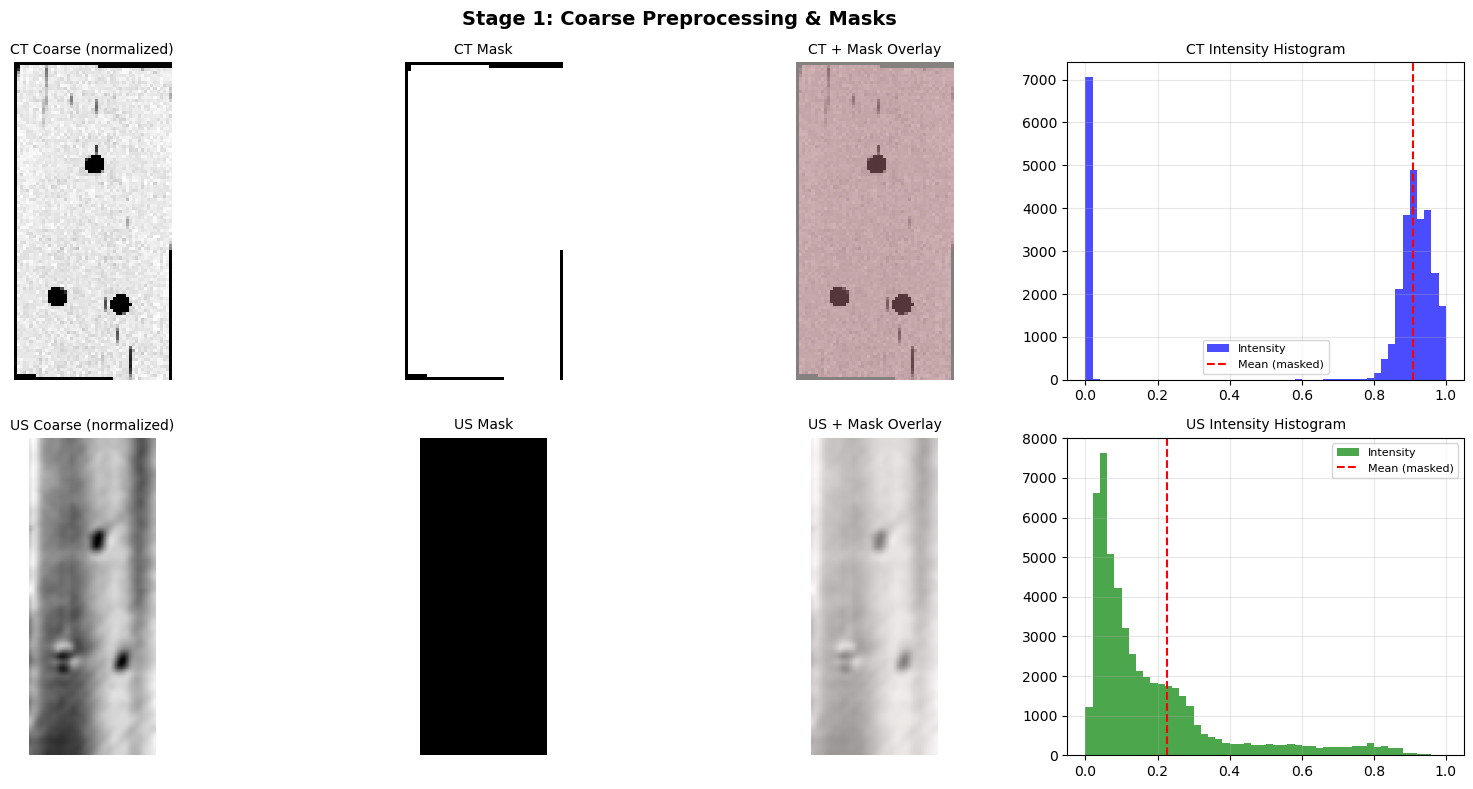


[STEP 3] Stage 1 registration (coarse)...
  TRANSFORM DIRECTION: Execute(fixed=US, moving=CT) → CT→US transform
  STRATEGY: Full 6-DOF for coarse stage (establishes 3D alignment)
  → Using MOMENTS initialization (with masks)
  → Initial transform: tx=2.13, ty=-4.74, tz=-1.39 mm

STARTING REGISTRATION
Fixed:  size=(46, 115, 10), spacing=(0.8, 0.8, 0.8)
Moving: size=(51, 103, 6), spacing=(0.8, 0.8, 0.8)
DOF Constraints: (True, True, True, True, True, True)
MI Bins: 1024, Sampling: 5.0%
Pyramid: [4, 2, 1]
Smoothing (mm): [2.5, 1.5, 0.0]
  → Level 1/3: shrink=4, sigma=2.5mm, DOF: rx=✓ ry=✓ rz=✓ tx=✓ ty=✓ tz=✓
  → Level 2/3: shrink=2, sigma=1.5mm, DOF: rx=✓ ry=✓ rz=✓ tx=✓ ty=✓ tz=✓
  → Level 3/3: shrink=1, sigma=0.0mm, DOF: rx=✓ ry=✓ rz=✓ tx=✓ ty=✓ tz=✓
  → Stop Condition: RegularStepGradientDescentOptimizerv4: Step too small after 527 iterations. Current step (6.02605e-13) is less than minimum step (1e-12).
  → Final Metric:   -2.835452

FINAL TRANSFORM PARAMETERS (moving→fixed)
  Rotatio

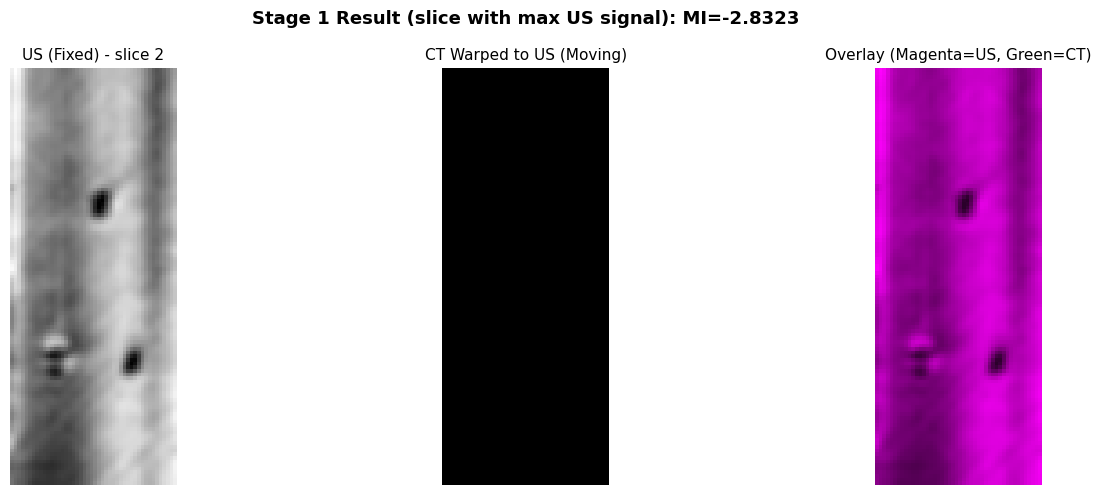


  Stage 1 Transform Parameters:
    Translations: tx=+2.52, ty=-4.51, tz=-2.43 mm
    Rotations:    rx=+0.13°, ry=+0.23°, rz=+0.26°
    MI improved:  -4.2798 → -2.8323 (Δ=+1.4475)

[STEP 4] Stage 2 preprocessing (fine)...
  Resampling CT to 0.5 mm isotropic...
    CT fine: (81, 164, 10)
  Keeping US at native resolution...
    US fine: (37, 92, 500)
  Normalizing intensities...
  Creating fine masks...
    CT fine mask: 106,404 voxels (80.1% of volume)
    US fine mask: 1,551,725 voxels (91.2% of volume)

  Visualizing Stage 2 masks...
    Using CT fine slice 5/9 (middle)
    Using US fine slice 94/499 (max signal: 1.000)


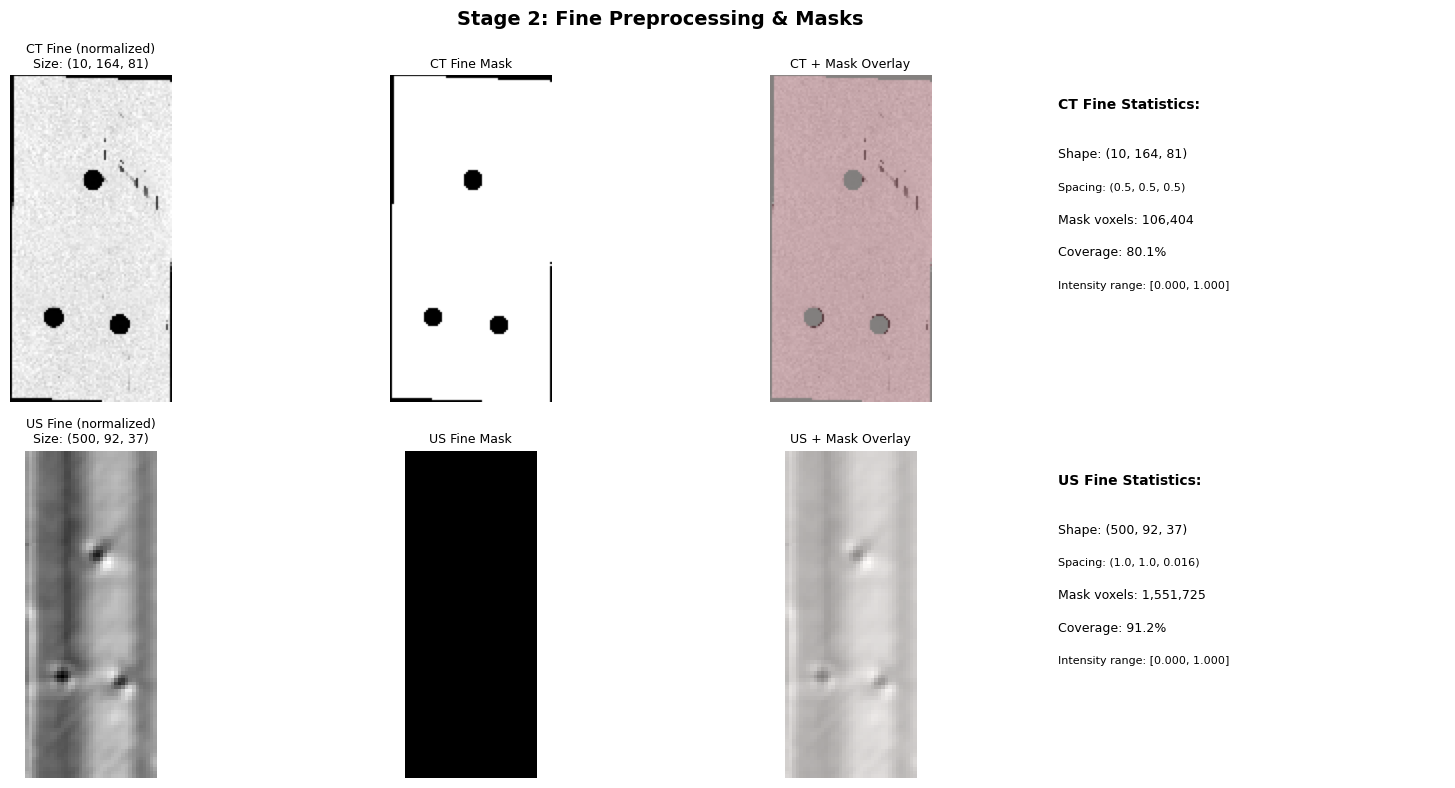


[STEP 5] Stage 2 registration (fine)...
  Initializing from Stage 1 transform...
  STRATEGY: In-plane constraints (tx, ty, rz) applied in fine stage
  → Initial transform: tx=2.52, ty=-4.51, tz=0.00 mm

STARTING REGISTRATION
Fixed:  size=(37, 92, 500), spacing=(1.0, 1.0, 0.016)
Moving: size=(81, 164, 10), spacing=(0.5, 0.5, 0.5)
DOF Constraints: (False, False, True, True, True, False)
MI Bins: 1024, Sampling: 5.0%
Pyramid: [4, 2, 1]
Smoothing (mm): [2.0, 1.0, 0.0]
  → Level 1/3: shrink=4, sigma=2.0mm, DOF: rx=✗ ry=✗ rz=✓ tx=✓ ty=✓ tz=✗
  → Level 2/3: shrink=2, sigma=1.0mm, DOF: rx=✗ ry=✗ rz=✓ tx=✓ ty=✓ tz=✗
  → Level 3/3: shrink=1, sigma=0.0mm, DOF: rx=✗ ry=✗ rz=✓ tx=✓ ty=✓ tz=✗
  → Stop Condition: RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 6431 iterations. Gradient magnitude (9.29459e-05) is less than gradient magnitude tolerance (0.0001).
  → Final Metric:   -1.002686

FINAL TRANSFORM PARAMETERS (moving→fixed)
  Rotation X (rx):  +0.000000° [LOCKED

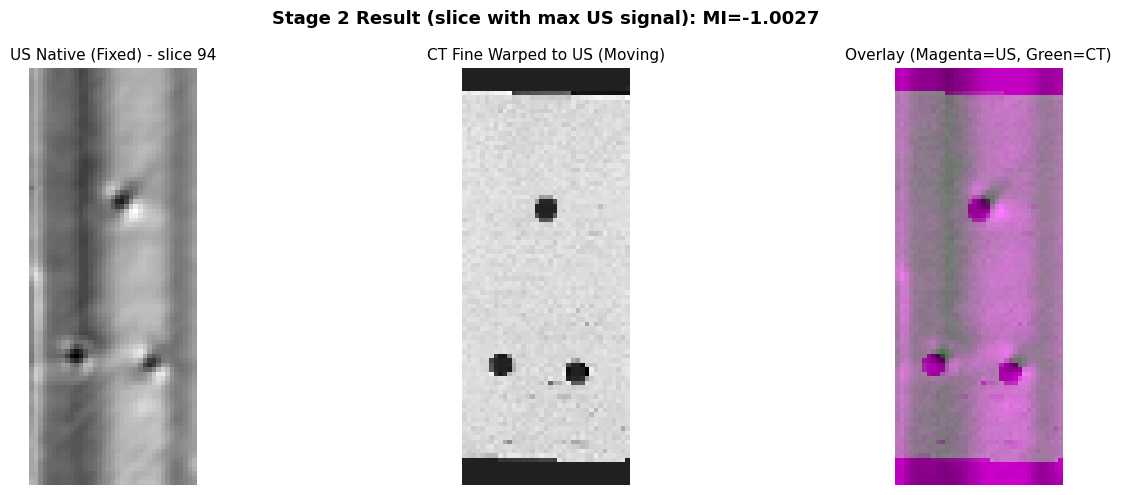


[STEP 8] Computing Dice scores...
  ✓ Saved: outputs/registration_inplane_test/us_mask_in_ct_space.tif
  Dice (CT space): 0.8888
  ✓ Saved: outputs/registration_inplane_test/ct_mask_in_us_space.tif
  Dice (US space): 0.6592

  Visualizing mask overlaps...


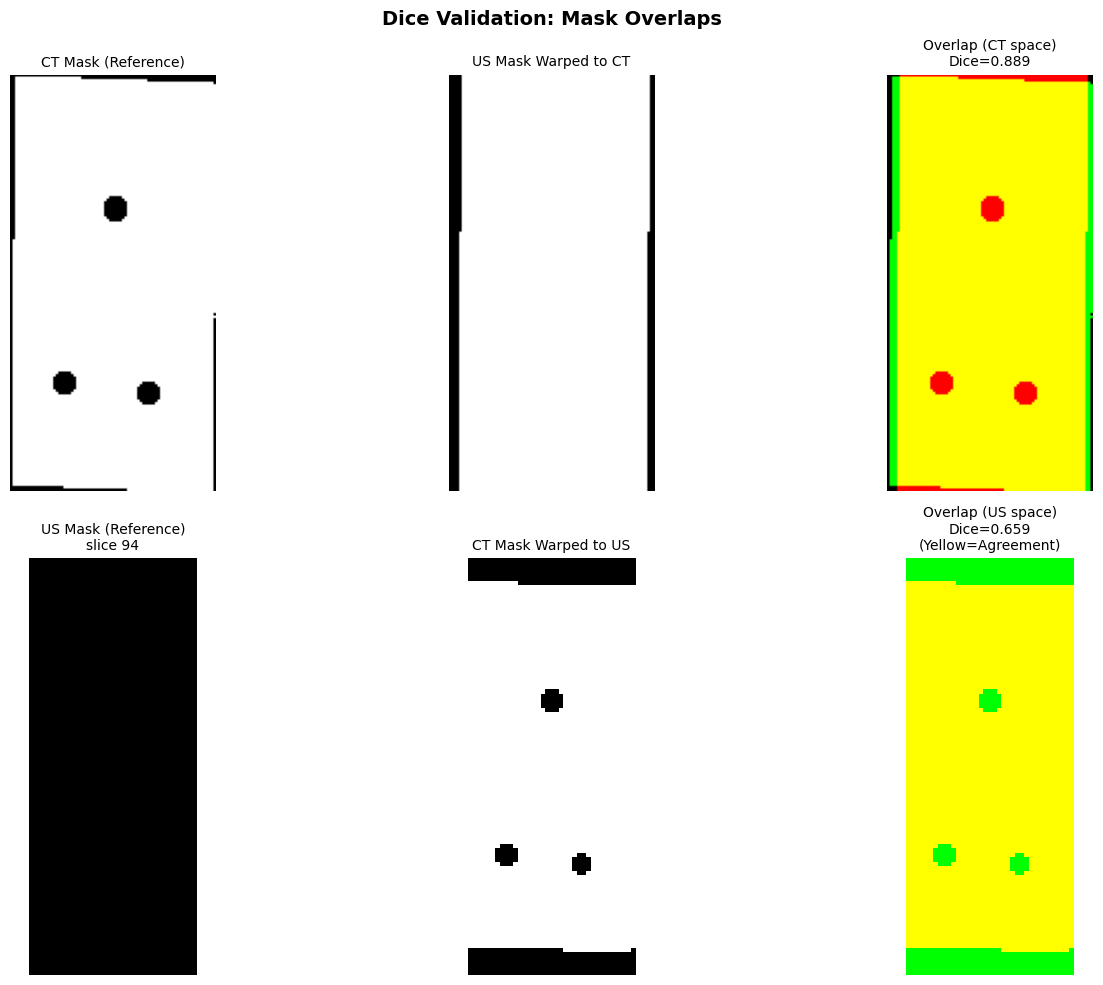


[STEP 9] Saving summary report...

✓ PIPELINE COMPLETE

REGISTRATION SUMMARY

Stage 1 (Coarse):
  Final MI: -2.832323
  Iterations: 1035

Stage 2 (Fine):
  Final MI: -1.002686
  Iterations: 10075

Validation (Dice Coefficients):
  CT space: 0.8888
  US space: 0.6592

Outputs saved to:
  outputs/registration_inplane_test

✓ PIPELINE EXECUTION COMPLETE

Next steps:
  - Run Cell 13-17 for QC visualizations
  - Inspect transform parameters in Cell 17
  - Review saved overlays and transforms in output directory


In [ ]:
# Cell 12: EXECUTE PIPELINE
# ==========================
# Run the complete 2-stage registration

# Create output directory
import os
os.makedirs(CONFIG['OUTPUT_DIR'], exist_ok=True)

# Run the pipeline
results = run_two_stage_inplane_registration(CONFIG)

# Print summary
print("\n" + "="*70)
print("REGISTRATION SUMMARY")
print("="*70)
print(f"\nStage 1 (Coarse):")
print(f"  Final MI: {results['metric_logs']['stage1'][-1]:.6f}")
print(f"  Iterations: {len(results['metric_logs']['stage1'])}")

print(f"\nStage 2 (Fine):")
print(f"  Final MI: {results['metric_logs']['stage2'][-1]:.6f}")
print(f"  Iterations: {len(results['metric_logs']['stage2'])}")

print(f"\nValidation (Dice Coefficients):")
if results['dice_ct_space'] is not None:
    print(f"  CT space: {results['dice_ct_space']:.4f}")
else:
    print(f"  CT space: N/A (inverse not available)")
print(f"  US space: {results['dice_us_space']:.4f}")

print(f"\nOutputs saved to:")
print(f"  {results['output_dir']}")

print("\n" + "="*70)
print("✓ PIPELINE EXECUTION COMPLETE")
print("="*70)
print("\nNext steps:")
print("  - Run Cell 13-17 for QC visualizations")
print("  - Inspect transform parameters in Cell 17")
print("  - Review saved overlays and transforms in output directory")
print("="*70)


Stage 1 (Coarse) QC


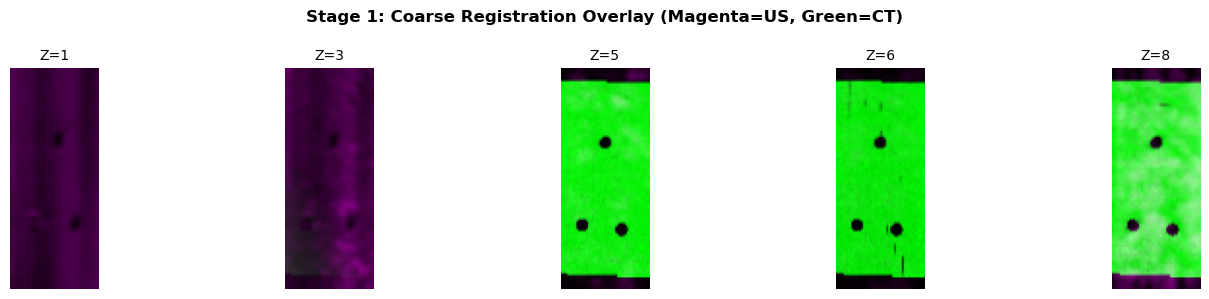

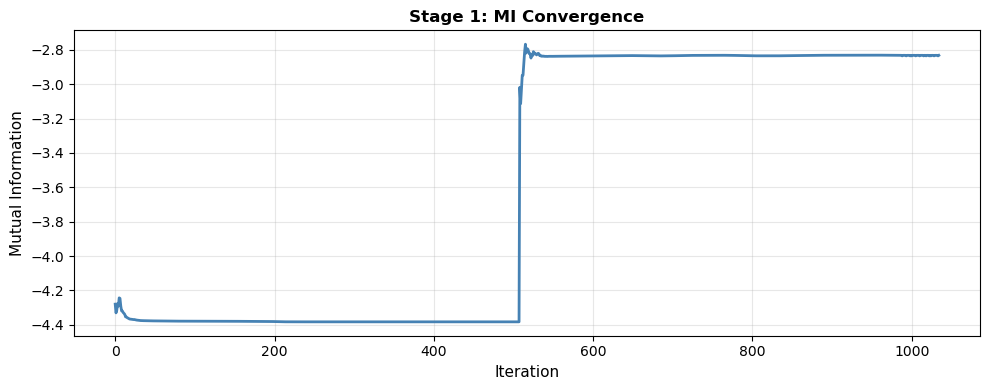

  Initial MI: -4.279813
  Final MI:   -2.832323
  Improvement: +1.447490


In [ ]:
# Cell 13: QC Visualization - Stage 1 (Coarse)
# ===============================================

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

print("Stage 1 (Coarse) QC")
print("="*70)

# Load Stage 1 overlay
out_dir = Path(CONFIG['OUTPUT_DIR'])
overlay_path = out_dir / "stage1_overlay_coarse.tif"

if overlay_path.exists():
    import tifffile
    overlay_vol = tifffile.imread(str(overlay_path))
    
    # Display a few slices
    num_slices = min(5, overlay_vol.shape[0])
    indices = extract_slice_indices(overlay_vol.shape, num_slices, axis=0)
    
    fig, axes = plt.subplots(1, len(indices), figsize=(3*len(indices), 3))
    if len(indices) == 1:
        axes = [axes]
    
    for i, idx in enumerate(indices):
        axes[i].imshow(overlay_vol[idx])
        axes[i].set_title(f"Z={idx}", fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle("Stage 1: Coarse Registration Overlay (Magenta=US, Green=CT)", 
                 fontsize=12, weight='bold')
    plt.tight_layout()
    plt.show()
    
    # Plot Stage 1 convergence
    metric_log_path = out_dir / "stage1_metric_log.txt"
    if metric_log_path.exists():
        metrics = np.loadtxt(metric_log_path)
        
        plt.figure(figsize=(10, 4))
        plt.plot(metrics[:, 1], linewidth=2, color='steelblue')
        plt.xlabel('Iteration', fontsize=11)
        plt.ylabel('Mutual Information', fontsize=11)
        plt.title('Stage 1: MI Convergence', fontsize=12, weight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"  Initial MI: {metrics[0, 1]:.6f}")
        print(f"  Final MI:   {metrics[-1, 1]:.6f}")
        print(f"  Improvement: {metrics[-1, 1] - metrics[0, 1]:+.6f}")
else:
    print(f"⚠️  Overlay not found: {overlay_path}")
    print("   Run Cell 12 first to execute the pipeline.")


Stage 2 (Fine) QC


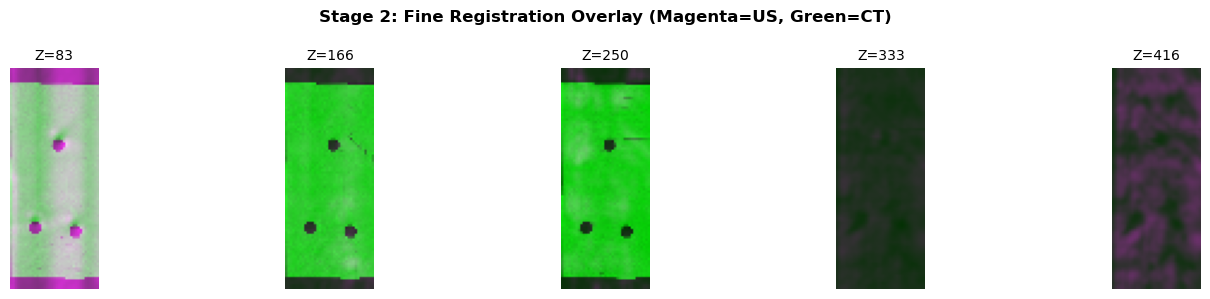

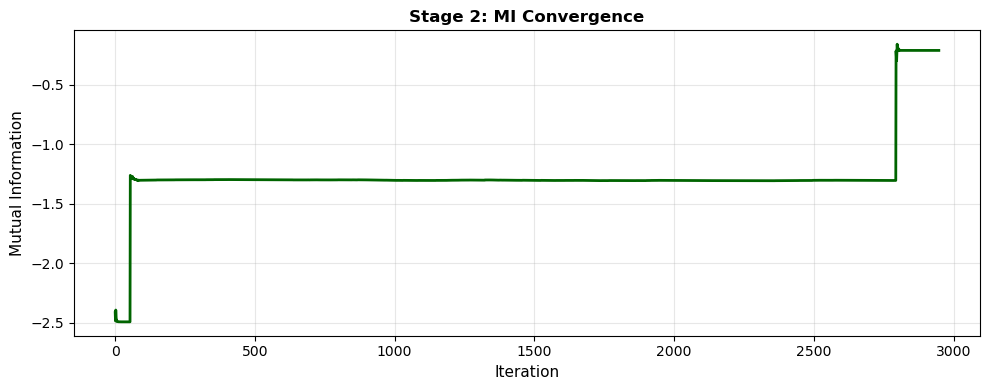

  Initial MI: -2.415059
  Final MI:   -0.212238
  Improvement: +2.202821


In [ ]:
# Cell 14: QC Visualization - Stage 2 (Fine)
# ============================================

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

print("Stage 2 (Fine) QC")
print("="*70)

# Load Stage 2 overlay
out_dir = Path(CONFIG['OUTPUT_DIR'])
overlay_path = out_dir / "stage2_overlay_fine.tif"

if overlay_path.exists():
    import tifffile
    overlay_vol = tifffile.imread(str(overlay_path))
    
    # Display a few slices
    num_slices = min(5, overlay_vol.shape[0])
    indices = extract_slice_indices(overlay_vol.shape, num_slices, axis=0)
    
    fig, axes = plt.subplots(1, len(indices), figsize=(3*len(indices), 3))
    if len(indices) == 1:
        axes = [axes]
    
    for i, idx in enumerate(indices):
        axes[i].imshow(overlay_vol[idx])
        axes[i].set_title(f"Z={idx}", fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle("Stage 2: Fine Registration Overlay (Magenta=US, Green=CT)", 
                 fontsize=12, weight='bold')
    plt.tight_layout()
    plt.show()
    
    # Plot Stage 2 convergence
    metric_log_path = out_dir / "stage2_metric_log.txt"
    if metric_log_path.exists():
        metrics = np.loadtxt(metric_log_path)
        
        plt.figure(figsize=(10, 4))
        plt.plot(metrics[:, 1], linewidth=2, color='darkgreen')
        plt.xlabel('Iteration', fontsize=11)
        plt.ylabel('Mutual Information', fontsize=11)
        plt.title('Stage 2: MI Convergence', fontsize=12, weight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"  Initial MI: {metrics[0, 1]:.6f}")
        print(f"  Final MI:   {metrics[-1, 1]:.6f}")
        print(f"  Improvement: {metrics[-1, 1] - metrics[0, 1]:+.6f}")
else:
    print(f"⚠️  Overlay not found: {overlay_path}")
    print("   Run Cell 12 first to execute the pipeline.")


Final Export: CT in US Space


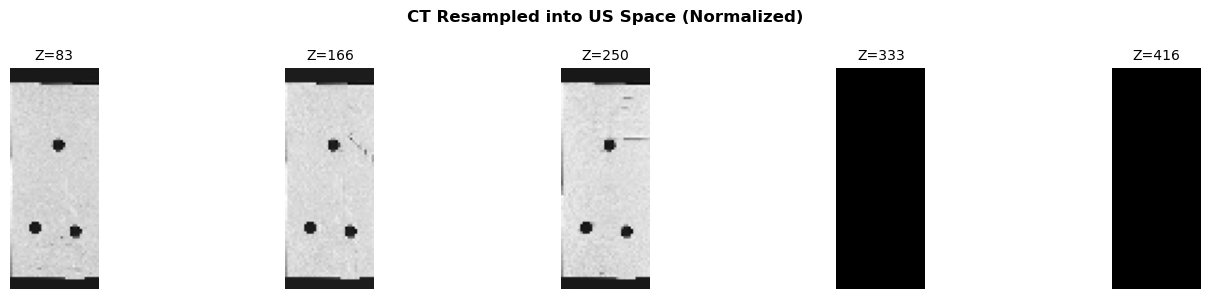

  CT in US space shape: (500, 92, 37)
  Intensity range: [-0.2896, 1.2359]
  CT in US space (RAW) intensity range: [-23.72, 268.12]


In [ ]:
# Cell 15: QC Visualization - CT in US Space
# ============================================

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import tifffile

print("Final Export: CT in US Space")
print("="*70)

out_dir = Path(CONFIG['OUTPUT_DIR'])

# Load CT in US space (normalized)
ct_in_us_path = out_dir / "ct_in_us_space_NORMALIZED.tif"

if ct_in_us_path.exists():
    ct_in_us = tifffile.imread(str(ct_in_us_path))
    
    # Display a few slices
    num_slices = min(5, ct_in_us.shape[0])
    indices = extract_slice_indices(ct_in_us.shape, num_slices, axis=0)
    
    fig, axes = plt.subplots(1, len(indices), figsize=(3*len(indices), 3))
    if len(indices) == 1:
        axes = [axes]
    
    for i, idx in enumerate(indices):
        # Normalize for display
        slice_img = ct_in_us[idx]
        slice_img = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min() + 1e-8)
        axes[i].imshow(slice_img, cmap='gray')
        axes[i].set_title(f"Z={idx}", fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle("CT Resampled into US Space (Normalized)", 
                 fontsize=12, weight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"  CT in US space shape: {ct_in_us.shape}")
    print(f"  Intensity range: [{ct_in_us.min():.4f}, {ct_in_us.max():.4f}]")
    
    # Also check raw version
    ct_in_us_raw_path = out_dir / "ct_in_us_space_RAW.tif"
    if ct_in_us_raw_path.exists():
        ct_in_us_raw = tifffile.imread(str(ct_in_us_raw_path))
        print(f"  CT in US space (RAW) intensity range: [{ct_in_us_raw.min():.2f}, {ct_in_us_raw.max():.2f}]")
else:
    print(f"⚠️  CT in US space not found: {ct_in_us_path}")
    print("   Run Cell 12 first to execute the pipeline.")


Quantitative Validation

Dice Coefficient Results:
----------------------------------------
Metric                              Value
----------------------------------------
Dice (CT space)                    0.8828
Dice (US space)                    0.6582
----------------------------------------


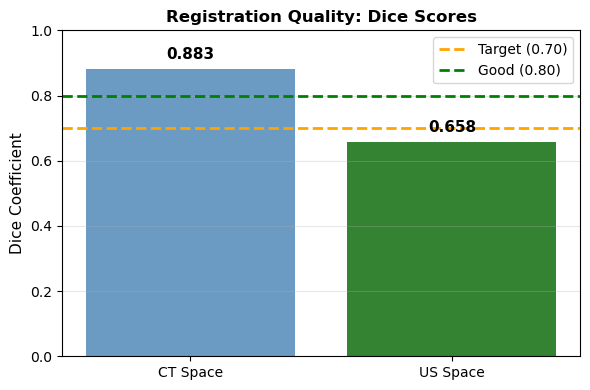


Interpretation:
  ✓ Excellent alignment (Dice ≥ 0.80)


In [ ]:
# Cell 16: Quantitative Validation Summary
# ==========================================

import matplotlib.pyplot as plt
import numpy as np
import json
from pathlib import Path

print("Quantitative Validation")
print("="*70)

out_dir = Path(CONFIG['OUTPUT_DIR'])
dice_path = out_dir / "dice_scores.json"

if dice_path.exists():
    with open(dice_path, 'r') as f:
        dice_scores = json.load(f)
    
    # Print table
    print("\nDice Coefficient Results:")
    print("-" * 40)
    print(f"{'Metric':<30} {'Value':>10}")
    print("-" * 40)
    
    if dice_scores['dice_ct_space'] is not None:
        print(f"{'Dice (CT space)':<30} {dice_scores['dice_ct_space']:>10.4f}")
    else:
        print(f"{'Dice (CT space)':<30} {'N/A':>10}")
    
    print(f"{'Dice (US space)':<30} {dice_scores['dice_us_space']:>10.4f}")
    print("-" * 40)
    
    # Bar chart
    labels = []
    values = []
    
    if dice_scores['dice_ct_space'] is not None:
        labels.append('CT Space')
        values.append(dice_scores['dice_ct_space'])
    
    labels.append('US Space')
    values.append(dice_scores['dice_us_space'])
    
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(labels, values, color=['steelblue', 'darkgreen'][:len(labels)], alpha=0.8)
    ax.set_ylabel('Dice Coefficient', fontsize=11)
    ax.set_title('Registration Quality: Dice Scores', fontsize=12, weight='bold')
    ax.set_ylim([0, 1])
    ax.axhline(0.7, color='orange', linestyle='--', linewidth=2, label='Target (0.70)')
    ax.axhline(0.8, color='green', linestyle='--', linewidth=2, label='Good (0.80)')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=11, weight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Interpretation
    print("\nInterpretation:")
    best_dice = max([v for v in dice_scores.values() if v is not None])
    if best_dice >= 0.80:
        print("  ✓ Excellent alignment (Dice ≥ 0.80)")
    elif best_dice >= 0.70:
        print("  ✓ Good alignment (Dice ≥ 0.70)")
    elif best_dice >= 0.60:
        print("  ⚠️  Moderate alignment (Dice ≥ 0.60)")
        print("     Consider adjusting hyperparameters or checking input data.")
    else:
        print("  ✗ Poor alignment (Dice < 0.60)")
        print("     Check:")
        print("       - Input spacing values are correct")
        print("       - Volumes have sufficient overlap")
        print("       - Masks are reasonable")
        print("       - Try increasing sampling_percent or adjusting pyramid")
else:
    print(f"⚠️  Dice scores not found: {dice_path}")
    print("   Run Cell 12 first to execute the pipeline.")


In [ ]:
# Cell 17: Transform Inspection
# ===============================

import SimpleITK as sitk
import numpy as np
from pathlib import Path

print("Transform Parameter Inspection")
print("="*70)

out_dir = Path(CONFIG['OUTPUT_DIR'])

# Load Stage 2 transform
tx_path = out_dir / "stage2_rigid_ct_to_us.tfm"

if tx_path.exists():
    tx = sitk.ReadTransform(str(tx_path))
    params = tx.GetParameters()
    
    print("\nFinal Transform (CT→US):")
    print("-" * 70)
    print(f"  Transform Type: {tx.GetName()}")
    print(f"  Number of Parameters: {tx.GetNumberOfParameters()}")
    print()
    
    # Parse parameters (Euler3D: [angleX, angleY, angleZ, tx, ty, tz])
    rx_deg = np.rad2deg(params[0])
    ry_deg = np.rad2deg(params[1])
    rz_deg = np.rad2deg(params[2])
    tx_mm = params[3]
    ty_mm = params[4]
    tz_mm = params[5]
    
    print("  Rotations:")
    print(f"    Around X-axis (Rx): {rx_deg:+10.6f}° {'[LOCKED]' if abs(rx_deg) < 1e-6 else ''}")
    print(f"    Around Y-axis (Ry): {ry_deg:+10.6f}° {'[LOCKED]' if abs(ry_deg) < 1e-6 else ''}")
    print(f"    Around Z-axis (Rz): {rz_deg:+10.6f}° {'[IN-PLANE]' if abs(rz_deg) > 1e-6 else '[LOCKED]'}")
    print()
    print("  Translations (mm):")
    print(f"    X direction (Tx):   {tx_mm:+10.4f} mm {'[IN-PLANE]' if abs(tx_mm) > 1e-4 else '[LOCKED]'}")
    print(f"    Y direction (Ty):   {ty_mm:+10.4f} mm {'[IN-PLANE]' if abs(ty_mm) > 1e-4 else '[LOCKED]'}")
    print(f"    Z direction (Tz):   {tz_mm:+10.4f} mm {'[LOCKED]' if abs(tz_mm) < 1e-4 else ''}")
    print("-" * 70)
    
    # Verify constraints
    print("\n Constraint Verification:")
    rx_ok = abs(rx_deg) < 1e-4
    ry_ok = abs(ry_deg) < 1e-4
    tz_ok = abs(tz_mm) < 1e-4
    
    if rx_ok and ry_ok and tz_ok:
        print("  ✓ All in-plane constraints satisfied (Rx=0, Ry=0, Tz=0)")
    else:
        print("  ⚠️  WARNING: Some constraints may not be satisfied:")
        if not rx_ok:
            print(f"     - Rx = {rx_deg:.6f}° (expected ~0)")
        if not ry_ok:
            print(f"     - Ry = {ry_deg:.6f}° (expected ~0)")
        if not tz_ok:
            print(f"     - Tz = {tz_mm:.6f} mm (expected ~0)")
    
    # In-plane motion magnitude
    in_plane_translation = np.sqrt(tx_mm**2 + ty_mm**2)
    print(f"\n  In-plane translation magnitude: {in_plane_translation:.4f} mm")
    if CONFIG['ALLOW_RZ']:
        print(f"  In-plane rotation (Rz): {rz_deg:.4f}°")
    
    # Load Stage 1 for comparison
    tx1_path = out_dir / "stage1_rigid_ct_to_us.tfm"
    if tx1_path.exists():
        tx1 = sitk.ReadTransform(str(tx1_path))
        params1 = tx1.GetParameters()
        
        print("\n  Stage 1 → Stage 2 Refinement:")
        print(f"    ΔRz: {np.rad2deg(params[2] - params1[2]):+.4f}°")
        print(f"    ΔTx: {params[3] - params1[3]:+.4f} mm")
        print(f"    ΔTy: {params[4] - params1[4]:+.4f} mm")
    
else:
    print(f"⚠️  Transform not found: {tx_path}")
    print("   Run Cell 12 first to execute the pipeline.")


Transform Parameter Inspection

Final Transform (CT→US):
----------------------------------------------------------------------
  Transform Type: Euler3DTransform
  Number of Parameters: 6

  Rotations:
    Around X-axis (Rx):  +0.000000° [LOCKED]
    Around Y-axis (Ry):  +0.000000° [LOCKED]
    Around Z-axis (Rz):  +0.623994° [IN-PLANE]

  Translations (mm):
    X direction (Tx):      +0.7444 mm [IN-PLANE]
    Y direction (Ty):      -5.3779 mm [IN-PLANE]
    Z direction (Tz):      +0.0000 mm [LOCKED]
----------------------------------------------------------------------

 Constraint Verification:
  ✓ All in-plane constraints satisfied (Rx=0, Ry=0, Tz=0)

  In-plane translation magnitude: 5.4292 mm
  In-plane rotation (Rz): 0.6240°

  Stage 1 → Stage 2 Refinement:
    ΔRz: +0.0061°
    ΔTx: -0.4367 mm
    ΔTy: -0.0965 mm


# Usage Notes & Troubleshooting

## Common Issues and Solutions

### 1. Low Dice Score (< 0.60)

**Symptoms:** Registration appears misaligned; overlays show poor agreement; Dice coefficient below 0.60.

**Possible Causes & Fixes:**

- **Incorrect spacing values**
  - **Fix:** Double-check `CT_SPACING_MM` and `US_SPACING_MM` in Cell 2. These must match the true physical spacing of your data.
  - Use metadata from acquisition or calibration if available.

- **Insufficient overlap**
  - **Fix:** Ensure CT and US volumes image the same region. Consider cropping to overlapping ROI before registration.

- **Poor masks**
  - **Fix:** Inspect saved masks (`ct_mask_*`, `us_mask_*`) in output directory. Adjust threshold values or preprocessing if masks don't cover material properly.

- **Optimizer stuck in local minimum**
  - **Fix:** Increase `SAMPLING_PERCENT` (try 0.10 or 0.15).
  - Adjust `LEARNING_RATE` (try 1.0 or 3.0).
  - Add more pyramid levels: `SHRINK_FACTORS: [16, 8, 4, 2, 1]`.

---

### 2. Optimizer Stalls Early

**Symptoms:** Convergence plot shows MI plateaus quickly; "Maximum number of iterations exceeded" in output.

**Possible Causes & Fixes:**

- **Learning rate too high**
  - **Fix:** Reduce `LEARNING_RATE` to 1.0 or 0.5.

- **Step size too large**
  - **Fix:** Reduce `MIN_STEP_LENGTH` to 1e-4 or 5e-4.

- **Excessive smoothing**
  - **Fix:** Reduce values in `SMOOTHING_SIGMAS_MM` (e.g., `[2.0, 1.0, 0.5, 0.0]`).

---

### 3. Wrong Transform Direction

**Symptoms:** Warped images appear inverted or completely misaligned.

**Important:** This pipeline uses **`Execute(fixed=US, moving=CT)`** → produces **CT→US** transform.

- To warp **CT into US space**: use `tx_stage2` directly.
- To warp **US into CT space**: use **inverse** (`tx_stage2_inv`).

---

### 4. Anisotropy Artifacts

**Symptoms:** Blurring or stretching in one direction; poor alignment along anisotropic axis.

**Fixes:**

- Ensure `SMOOTHING_SIGMAS_MM` are in **millimeters** (not voxels). The pipeline already handles this correctly.
- Keep `STAGE2_US_KEEP_NATIVE=True` to preserve US native resolution in fine stage.
- Verify spacing values are accurate.

---

### 5. Constraints Not Enforced

**Symptoms:** Transform inspection (Cell 17) shows non-zero Rx, Ry, or Tz.

**Fix:**

- This should not happen if the pipeline ran correctly. The constraints are enforced at initialization, every iteration, and at the end.
- If you see violations > 1e-4, there may be a numerical precision issue. Re-run Cell 12.

---

## Hyperparameter Tuning Guide

### When to adjust what:

| Problem | Parameter to Adjust | Suggested Values |
|---------|---------------------|------------------|
| Low Dice, poor alignment | `SAMPLING_PERCENT` ↑ | 0.10, 0.15 |
| Optimizer oscillates | `LEARNING_RATE` ↓ | 1.0, 0.5 |
| Converges too fast | `MAX_ITERS_PER_LEVEL` ↑ | 300, 500 |
| Too slow | `SHRINK_FACTORS` ↓ | `[4, 2, 1]` |
| Noisy US dominates | `US_GAUSSIAN_SIGMA_VOXELS` ↑ | 1.5, 2.0 |
| Need finer alignment | `STAGE2_CT_SPACING_MM` ↓ | 0.3, 0.4 |

---

## Output Files Reference

| File | Description |
|------|-------------|
| `stage1_rigid_ct_to_us.tfm` | Coarse transform (CT→US) |
| `stage2_rigid_ct_to_us.tfm` | Fine transform (CT→US) — **use this** |
| `stage2_rigid_us_to_ct_INVERSE.tfm` | Inverse for US→CT warping |
| `stage1_overlay_coarse.tif` | RGB overlay (Stage 1 QC) |
| `stage2_overlay_fine.tif` | RGB overlay (Stage 2 QC) |
| `ct_in_us_space_NORMALIZED.tif` | CT warped to US (for visualization) |
| `ct_in_us_space_RAW.tif` | CT warped to US (preserves intensities) |
| `ct_mask_in_us_space.tif` | CT mask warped to US |
| `us_mask_in_ct_space.tif` | US mask warped to CT |
| `dice_scores.json` | Quantitative validation |
| `registration_report.txt` | Summary report |
| `stage*_metric_log.txt` | Iteration-wise MI values |

---

## Advanced Usage

### Applying transforms to new volumes

See **Cell 19** for a helper function to apply saved transforms to new data.

### Exporting to other software

- SimpleITK `.tfm` files can be loaded in ITK-SNAP, 3D Slicer, or converted to other formats.
- For MATLAB: use `sitk.ReadTransform()` in Python, extract parameters, and reconstruct in MATLAB.

---

## References

- **SimpleITK Documentation:** [simpleitk.org](https://simpleitk.org/)
- **Mattes MI:** Mattes et al., "PET-CT image registration in the chest using free-form deformations," IEEE TMI 2003.
- **Multi-resolution registration:** Thevenaz & Unser, "Optimization of mutual information for multiresolution image registration," IEEE TIP 2000.


In [ ]:
# Cell 19: Apply Transform to New Volumes (Optional)
# ====================================================
# Helper function to apply saved transforms to new data

import SimpleITK as sitk
from pathlib import Path

def apply_saved_transform(
    moving_volume_path,
    reference_volume_path,
    transform_path,
    output_path,
    interpolator='linear'
):
    """
    Apply a saved transform to warp a moving volume into reference space.
    
    Use this to apply the registration result to other volumes (e.g., label maps,
    additional CT scans, segmentation masks).
    
    Parameters
    ----------
    moving_volume_path : str
        Path to volume to be warped (e.g., new CT scan).
    reference_volume_path : str
        Path to reference volume that defines output space (e.g., US).
    transform_path : str
        Path to saved transform (.tfm or .h5), typically 'stage2_rigid_ct_to_us.tfm'.
    output_path : str
        Where to save the warped volume.
    interpolator : str
        'linear', 'nearest', or 'bspline'.
        Use 'nearest' for label maps/segmentations to preserve integer labels.
    
    Returns
    -------
    sitk.Image
        Warped volume in reference space.
    
    Example
    -------
    >>> # Apply to a new CT volume
    >>> apply_saved_transform(
    ...     moving_volume_path='/path/to/new_ct.tif',
    ...     reference_volume_path=CONFIG['US_PATH'],
    ...     transform_path='./outputs/registration_inplane_test/stage2_rigid_ct_to_us.tfm',
    ...     output_path='./outputs/new_ct_in_us_space.tif',
    ...     interpolator='bspline'
    ... )
    >>> 
    >>> # Apply to a CT segmentation (use nearest neighbor)
    >>> apply_saved_transform(
    ...     moving_volume_path='/path/to/ct_segmentation.tif',
    ...     reference_volume_path=CONFIG['US_PATH'],
    ...     transform_path='./outputs/registration_inplane_test/stage2_rigid_ct_to_us.tfm',
    ...     output_path='./outputs/ct_segmentation_in_us_space.tif',
    ...     interpolator='nearest'
    ... )
    """
    
    print(f"Applying transform to new volume...")
    print(f"  Moving: {Path(moving_volume_path).name}")
    print(f"  Reference: {Path(reference_volume_path).name}")
    print(f"  Transform: {Path(transform_path).name}")
    
    # Load volumes
    moving = sitk.ReadImage(str(moving_volume_path))
    reference = sitk.ReadImage(str(reference_volume_path))
    
    # Load transform
    transform = sitk.ReadTransform(str(transform_path))
    
    # Select interpolator
    interp_map = {
        'linear': sitk.sitkLinear,
        'nearest': sitk.sitkNearestNeighbor,
        'bspline': sitk.sitkBSpline,
    }
    interp = interp_map.get(interpolator.lower(), sitk.sitkLinear)
    
    # Resample
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference)
    resampler.SetTransform(transform)
    resampler.SetInterpolator(interp)
    resampler.SetDefaultPixelValue(0)
    
    warped = resampler.Execute(moving)
    
    # Save
    sitk.WriteImage(warped, str(output_path))
    print(f"  ✓ Saved: {output_path}")
    
    return warped


# Example usage (commented out — uncomment and edit paths to use):
# 
# warped_ct = apply_saved_transform(
#     moving_volume_path='/path/to/your/new_ct_volume.tif',
#     reference_volume_path=CONFIG['US_PATH'],
#     transform_path=str(Path(CONFIG['OUTPUT_DIR']) / 'stage2_rigid_ct_to_us.tfm'),
#     output_path=str(Path(CONFIG['OUTPUT_DIR']) / 'new_ct_warped.tif'),
#     interpolator='bspline'
# )

print("✓ Transform application helper loaded.")
print("\nTo use this function:")
print("  1. Uncomment the example at the bottom of this cell")
print("  2. Edit paths to point to your new volume")
print("  3. Run the cell")


✓ Transform application helper loaded.

To use this function:
  1. Uncomment the example at the bottom of this cell
  2. Edit paths to point to your new volume
  3. Run the cell
